In [1]:
# Bioinformatics
import pysam
from pysam import VariantFile

# Data Analysis
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

# General
import sys
import os
import re

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mpl.rcParams['figure.dpi'] = 300

## General samples and cluster informations

In [2]:
conditions_colors = {
    "30H": (0.0,0.0,1.0,0.8), # blue
    "30H_del": (0.0,0.7,1.0,0.25), # turquoise
    "30D": (1.0,0.5,0.0,0.8), # orangered
    "30D_del": (1.0,0.75,0.0,0.25), # orange
    "0Gy": (0.5,0.5,0.5,0.8), # dark grey
    "0Gy_del": (0.7,0.7,0.7,0.25), # lighter grey
    "100Gy": (0.7,0.0,0.6,0.8), # purple
    "100Gy_del": (1.0,0.0,0.8,0.25), # pinkish
    "250Gy": (0.0,0.75,0.0,0.8), # darkgreen
    "250Gy_del": (0.0,1.0,0.0,0.25), # limegreen
    "500Gy": (1.0,0.0,0.0,0.8), # red
    "500Gy_del": (1.0,0.5,0.5,0.25), # pink
    "H": (0.0,0.0,1.0,0.8),
    "H_del": (0.0,0.7,1.0,0.25),
    "D": (1.0,0.25,0.0,0.8),
    "D_del": (1.0,0.75,0.0,0.25),
}

conditions_cmap = {
    "30H":plt.cm.Blues,
    "30D":plt.cm.Oranges,
    "0Gy":plt.cm.Greys,
    "100Gy":plt.cm.Purples,
    "250Gy":plt.cm.Greens,
    "500Gy":plt.cm.Reds,
    "H":plt.cm.Blues,
    "D":plt.cm.Oranges,
}

conditions_names = {
    "30H": "GR Hydrated",
    "30D": "GR Desiccated",
    "0Gy": "GR 0Gy IR",
    "100Gy": "GR 100Gy IR",
    "250Gy": "GR 250Gy IR",
    "500Gy": "GR 500Gy IR",
    "H": "ME Hydrated",
    "D": "ME Desiccated"
}

conditions_shape = {
    "30H": "o",
    "30D": "o",
    "0Gy": "o",
    "100Gy": "o",
    "250Gy": "o",
    "500Gy": "o",
    "H": "d",
    "D": "d"
}

col_MA = (55/255, 126/255, 184/255)
col_ARC = (255/255, 127/255, 0/255)
col_TE = (152/255, 78/255, 163/255, 0.65)

# LENGTHS OF CHROMOSOMES
reference = "/mnt/urbe2/disk3/Antoine/19-11-21_VariantCalling_ARC/input/reference.fa"
fai = "/mnt/urbe2/disk3/Antoine/19-11-21_VariantCalling_ARC/input/reference.fa.fai"
lengths = {}
for line in open(fai, 'r') :
    s = line.strip().split()
    lengths[s[0]] = int(s[1])

# TELOMERES
telomeres = {
    "Chrom_1":([0,1500000], [11000000, 18146847]),
    "Chrom_2":([0,2000000], [15000000, 16274841]),
    "Chrom_3":([0,4000000], [13500000, 20354777]),
    "Chrom_4":([0,1000000], [14000000, 15224634]),
    "Chrom_5":([0,5000000], [15500000, 16930519]),
    "Chrom_6":([0,2000000], [12000000, 13893210]),
}

# POSITIONS OF GENES, CDS AND REPEATS 
genes = "/mnt/urbe2/disk3/Antoine/19-11-21_VariantCalling_ARC/input/Avaga.genes.bed"
cds = "/mnt/urbe2/disk3/Antoine/19-11-21_VariantCalling_ARC/input/Avaga.CDS.bed"
repeats = "/mnt/urbe2/disk3/Antoine/19-11-21_VariantCalling_ARC/input/avaga.TEannotation.26-02-20.defragmentedDraftAnnot.bed"

# REPEATS DATAFRAME
reps = {"CHR":[], "START":[], "END":[]}
for line in open(repeats, "r") :
    s = line.strip().split("\t")
    reps["CHR"].append(s[0])
    reps["START"].append(int(s[1]))
    reps["END"].append(int(s[2]))
    
repdf = pd.DataFrame().from_dict(reps)

In [3]:
clr = plt.rcParams['axes.prop_cycle'].by_key()['color']

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return list(int(value[i:i + lv // 3], 16)/255 for i in range(0, lv, lv // 3))

colors = [hex_to_rgb(c) for c in clr]
print(colors)

[[0.12156862745098039, 0.4666666666666667, 0.7058823529411765], [1.0, 0.4980392156862745, 0.054901960784313725], [0.17254901960784313, 0.6274509803921569, 0.17254901960784313], [0.8392156862745098, 0.15294117647058825, 0.1568627450980392], [0.5803921568627451, 0.403921568627451, 0.7411764705882353], [0.5490196078431373, 0.33725490196078434, 0.29411764705882354], [0.8901960784313725, 0.4666666666666667, 0.7607843137254902], [0.4980392156862745, 0.4980392156862745, 0.4980392156862745], [0.7372549019607844, 0.7411764705882353, 0.13333333333333333], [0.09019607843137255, 0.7450980392156863, 0.8117647058823529]]


In [4]:
cml = mpl.cm.tab20.colors
colors = [list(c) for c in cml]
#colors

# Deletion ARC Smooth evolution ONT

### Deletion size for fitting must be 500Kb centered on the deletion

### Read coverage once for all deletions

In [ ]:
cov_ont = pd.read_csv(
    "/media/urbe/MyADrive1/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_ont = cov_ont.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ONT"})

In [ ]:
cov_anc = pd.read_csv(
    "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/coverage/ancestor.sorted.CALL.bam.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_anc = cov_anc.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ANC"})

In [ ]:
cov_ilu = pd.read_csv(
    "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/coverage/P500_C18_E3.sorted.CALL.bam.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_ilu = cov_ilu.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ILU"})

# GR P500C18E3 all deletions

In [ ]:
vcf_ARC = "/mnt/urbe2/disk3/Antoine/19-11-21_VariantCalling_ARC/jointgenotyping/merged_allsites.GETS.vcf"
vcf_ONT = "/mnt/urbe2/disk3/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.bam.bcftools_mpileup.bcf"

def parse_all_data(vcf_arc, vcf_ont, ancestor, sample, sample_ont) :
     
    dc = {
        "CHROM":[], "POS":[], "QUAL":[], "ALS":[], # general
        "AAL":[], "ADP":[], "AAD":[], "AAF":[], # ancestor
        "IAL":[], "IDP":[], "IAD":[], "IAF":[], "IGT":[], # illumina offspring
    }
    
    # Parse variant file
    vcf_in = VariantFile(vcf_arc)  # auto-detect input format
    vcf_in.subset_samples([ancestor, sample])
    
    # For record in sample
    for i, rec in enumerate(vcf_in) :
        if i % 10000000 == 0 :
            print("Read {} records...".format(i))
        
        dc["CHROM"].append(rec.chrom)
        dc["POS"].append(rec.pos)
        dc["AAL"].append([al for n, al in enumerate(rec.alleles) if n in rec.samples[ancestor]["GT"]])
        dc["IAL"].append([al for n, al in enumerate(rec.alleles) if n in rec.samples[sample]["GT"]])
        dc["QUAL"].append(rec.qual)
        
        dc["ALS"].append(rec.alleles)
        
        try :
            dc["IGT"].append(rec.samples[sample]["GT"])
        except :
            dc["IGT"].append(None)
        
        try :
            dc["ADP"].append(rec.samples[ancestor]["DP"])
        except :
            dc["ADP"].append(None)
        try :
            dc["IDP"].append(rec.samples[sample]["DP"])
        except :
            dc["IDP"].append(None)
        
        try :
            dc["AAD"].append(rec.samples[ancestor]["AD"])
            try :
                dc["AAF"].append(max(rec.samples[ancestor]["AD"])/rec.samples[ancestor]["DP"])
            except :
                dc["AAF"].append(None)
        except :
            dc["AAD"].append(None)
            dc["AAF"].append(None)
        
        try :
            dc["IAD"].append(rec.samples[sample]["AD"])
            try :
                dc["IAF"].append(max(rec.samples[sample]["AD"])/rec.samples[sample]["DP"])
            except :
                dc["IAF"].append(None)
        except :
            dc["IAD"].append(None)
            dc["IAF"].append(None)
        
    vcf_in.close()
    df_illu = pd.DataFrame.from_dict(dc)
    
    # Now for ONT data
    dc = {
        "CHROM":[], "POS":[], "QUAL":[], "ALS":[], # general
        "OAL":[], "ODP":[], "OAD":[], "OAF":[], "OGT":[], # ONT offspring (+6 months culture)
    }
    
    vcf_in = VariantFile(vcf_ont)  # auto-detect input format
    
    # For record in sample
    for rec in vcf_in :
        
        dc["CHROM"].append(rec.chrom)
        dc["POS"].append(rec.pos)
        dc["OAL"].append([al for n, al in enumerate(rec.alleles) if n in rec.samples[sample_ont]["GT"]])
        dc["QUAL"].append(rec.qual)
        dc["ALS"].append(rec.alleles)
        
        try :
            dc["OGT"].append(rec.samples[sample_ont]["GT"])
        except :
            dc["OGT"].append(None)
        
        try :
            dc["ODP"].append(rec.samples[sample_ont]["DP"])
        except :
            dc["ODP"].append(None)
        
        try :
            dc["OAD"].append(rec.samples[sample_ont]["AD"])
            try : # WARNING : HERE SOME ALLELE DEPTH IS MISSING SO WE TAKE 1-AF to get the max AF info
                oaf = max(rec.samples[sample_ont]["AD"])/rec.samples[sample_ont]["DP"]
                if oaf < 0.5 :
                    oaf = 1 - oaf
                dc["OAF"].append(oaf)
                
            except :
                dc["OAF"].append(None)
        except :
            dc["OAD"].append(None)
            dc["OAF"].append(None)
        
    vcf_in.close()
    df_ONT = pd.DataFrame.from_dict(dc)
    
    print("data from illumina and ONT variants")
    print("Illumina: {} variants".format(len(df_illu)))
    print("ONT: {} variants".format(len(df_ONT)))
    print("Merge variants from ancestor and offspring illumina with offspring ONT variants")
    total_df = pd.merge(df_illu, df_ONT, on=["CHROM", "POS"], how="outer")
    print(len(total_df))
    
    return total_df

# All variants and coverage

### Do once then read pickled dataframe

In [13]:
sample_ont = "/mnt/urbe2/disk3/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.bam"
print("Parse variants")
total_df = parse_all_data(vcf_ARC, vcf_ONT, "ancestor", "P500_C18_E3", sample_ont)
print(len(total_df))
print("Add ancestor coverage")
total_df = pd.merge(total_df, cov_anc, on=["CHROM", "POS"], how="inner")
print(len(total_df))
print("Add offspring illumina coverage")
total_df = pd.merge(total_df, cov_ilu, on=["CHROM", "POS"], how="inner")
print(len(total_df))
print("Add offspring ONT coverage")
total_df = pd.merge(total_df, cov_ont, on=["CHROM", "POS"], how="inner")
print(len(total_df))
total_df

Parse variants
Read 0 records...
Read 10000000 records...
Read 20000000 records...
Read 30000000 records...
Read 40000000 records...
Read 50000000 records...
Read 60000000 records...
Read 70000000 records...
Read 80000000 records...
Read 90000000 records...
Read 100000000 records...
data from illumina and ONT variants
Illumina: 100824817 variants
ONT: 1375026 variants
Merge variants from ancestor and offspring illumina with offspring ONT variants
100824819
100824819
Add ancestor coverage
100824813
Add offspring illumina coverage
100824813
Add offspring ONT coverage
100824813


CHROM       POS  QUAL_x ALS_x  AAL    ADP     AAD       AAF  IAL  \
0          Chrom_3         1     NaN  (A,)   []    0.0    (0,)       NaN   []   
1          Chrom_3         2     NaN  (C,)   []    0.0    (0,)       NaN   []   
2          Chrom_3         3     NaN  (T,)   []    0.0    (0,)       NaN   []   
3          Chrom_3         4     NaN  (T,)   []    0.0    (0,)       NaN   []   
4          Chrom_3         5     NaN  (G,)   []    0.0    (0,)       NaN   []   
...            ...       ...     ...   ...  ...    ...     ...       ...  ...   
100824808  Chrom_6  13893207     NaN  (C,)   []  134.0  (133,)  0.992537   []   
100824809  Chrom_6  13893208     NaN  (A,)   []  133.0  (133,)  1.000000   []   
100824810  Chrom_6  13893209     NaN  (C,)   []  131.0  (130,)  0.992366   []   
100824811  Chrom_3   2895068     NaN   NaN  NaN    NaN     NaN       NaN  NaN   
100824812  Chrom_1   7749327     NaN   NaN  NaN    NaN     NaN       NaN  NaN   

           IDP  ...     QUAL_y   ALS_y     OAL    ODP         OAD       OAF  \
0          0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
1          0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
2          0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
3          0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
4          0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
...        ...  ...        ...     ...     ...    ...         ...       ...   
100824808  0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
100824809  0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
100824810  0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
100824811  NaN  ...  71.007423  (C, T)  [C, T]  382.0  (277, 101)  0.725131   
100824812  NaN  ...   4.128477  (A, T)  [A, T]  531.0  (408, 113)  0.768362   

              OGT COV_ANC  COV_ILU COV_ONT  
0             NaN       0        0      23  
1             NaN       0        0      24  
2             NaN       0        0      25  
3             NaN       0        0      26  
4             NaN       0        0      27  
...           ...     ...      ...     ...  
100824808     NaN     133        0       0  
100824809     NaN     131        0       0  
100824810     NaN     129        0       0  
100824811  (0, 1)     260      218     826  
100824812  (0, 1)     250      226     914  

[100824813 rows x 23 columns]

In [14]:
total_df.to_pickle("GR_P500C18E3_AF_COV_Illumina_ONT.pkl.bz2", compression="bz2")

### Read data from pickle

In [5]:
total_df = pd.read_pickle("GR_P500C18E3_AF_COV_Illumina_ONT.pkl.bz2")
total_df

CHROM       POS  QUAL_x ALS_x  AAL    ADP     AAD       AAF  IAL  \
0          Chrom_3         1     NaN  (A,)   []    0.0    (0,)       NaN   []   
1          Chrom_3         2     NaN  (C,)   []    0.0    (0,)       NaN   []   
2          Chrom_3         3     NaN  (T,)   []    0.0    (0,)       NaN   []   
3          Chrom_3         4     NaN  (T,)   []    0.0    (0,)       NaN   []   
4          Chrom_3         5     NaN  (G,)   []    0.0    (0,)       NaN   []   
...            ...       ...     ...   ...  ...    ...     ...       ...  ...   
100824808  Chrom_6  13893207     NaN  (C,)   []  134.0  (133,)  0.992537   []   
100824809  Chrom_6  13893208     NaN  (A,)   []  133.0  (133,)  1.000000   []   
100824810  Chrom_6  13893209     NaN  (C,)   []  131.0  (130,)  0.992366   []   
100824811  Chrom_3   2895068     NaN   NaN  NaN    NaN     NaN       NaN  NaN   
100824812  Chrom_1   7749327     NaN   NaN  NaN    NaN     NaN       NaN  NaN   

           IDP  ...     QUAL_y   ALS_y     OAL    ODP         OAD       OAF  \
0          0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
1          0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
2          0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
3          0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
4          0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
...        ...  ...        ...     ...     ...    ...         ...       ...   
100824808  0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
100824809  0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
100824810  0.0  ...        NaN     NaN     NaN    NaN         NaN       NaN   
100824811  NaN  ...  71.007423  (C, T)  [C, T]  382.0  (277, 101)  0.725131   
100824812  NaN  ...   4.128477  (A, T)  [A, T]  531.0  (408, 113)  0.768362   

              OGT COV_ANC  COV_ILU COV_ONT  
0             NaN       0        0      23  
1             NaN       0        0      24  
2             NaN       0        0      25  
3             NaN       0        0      26  
4             NaN       0        0      27  
...           ...     ...      ...     ...  
100824808     NaN     133        0       0  
100824809     NaN     131        0       0  
100824810     NaN     129        0       0  
100824811  (0, 1)     260      218     826  
100824812  (0, 1)     250      226     914  

[100824813 rows x 23 columns]

# Plot for main Fig.

In [6]:
default_legend_fontsize = 8
default_tick_fontsize = 8
default_xlabel_fontsize = 8
default_ylabel_fontsize = 10
default_title_fontsize = 8

In [7]:
def plot_region(
    data, chrom, start, end, bs, be, byt,
    min_qual=10, mincovy=0.26, maxcovy=1.2,
    nbins=100, mafy=1.15, show_sites=False,
    vlines=[], show_af_df = False,
    legend_fontsize = default_legend_fontsize, 
    ylabel_fontsize = default_ylabel_fontsize,
    xlabel_fontsize = default_xlabel_fontsize,
    tick_fontsize = default_tick_fontsize,
) :
    
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6.5,4.5))

    flt = data.query("CHROM == @chrom & POS > @start & POS < @end & QUAL_y >= @min_qual")
    flt = flt.dropna()

    if show_af_df:
        display(flt.query("IAF > 0.95 & OAF > 0.8")[["CHROM","POS","AAF","IAF","OAF"]])
    # top allele frequency
    ax = axs[0]

    AAF = flt["AAF"].rolling(window=nbins).mean()
    AAF_std = flt["AAF"].rolling(window=nbins).std()
    IAF = flt["IAF"].rolling(window=nbins).mean()
    IAF_std = flt["IAF"].rolling(window=nbins).std()
    OAF = flt["OAF"].rolling(window=nbins).mean()
    OAF_std = flt["OAF"].rolling(window=nbins).std()

    ax.plot(flt["POS"], AAF, color=colors[0], lw=1.5, zorder=15, label="Ancestor")
    if not show_sites :
        ax.fill_between(flt["POS"], AAF+AAF_std, AAF-AAF_std, facecolor=colors[1]+[0.5], zorder=10)

    ax.plot(flt["POS"], IAF, color=colors[2], lw=1.5, zorder=15, label="Offspring (Illumina)")
    if not show_sites :
        ax.fill_between(flt["POS"], IAF+IAF_std, IAF-IAF_std, facecolor=colors[3]+[0.5], zorder=10)

    ax.plot(flt["POS"], OAF, color=colors[6], lw=1.5, zorder=15, label="Offspring +6 months (Nanopore)")
    if not show_sites :
        ax.fill_between(flt["POS"], OAF+OAF_std, OAF-OAF_std, facecolor=colors[7]+[0.25], zorder=10)

    if show_sites :
        ax.scatter(flt["POS"], flt["AAF"], s=3, facecolor=colors[1]+[0.2], ec="k", lw=0.0, zorder=1)
        ax.scatter(flt["POS"], flt["IAF"], s=3, facecolor=colors[3]+[0.2], ec="k", lw=0.0, zorder=1)
        ax.scatter(flt["POS"], flt["OAF"], s=3, facecolor=colors[7]+[0.2], ec="k", lw=0.0, zorder=1)
    
    ax.yaxis.grid(True, zorder=1)
    ax.set_ylim(0.45, mafy)
    ax.set_yticks([0.5, 0.75, 1.0])
    ax.tick_params(labelsize=tick_fontsize)
    ax.set_ylabel("Allele\nFrequency", fontsize=ylabel_fontsize)

    ax.legend(ncol=3, fontsize=legend_fontsize, frameon=False)

    # bottom Coverage
    ax = axs[1]

    ADP_scaled = flt["COV_ANC"]/341
    Arol = ADP_scaled.rolling(window=nbins).mean()
    Arol_std = ADP_scaled.rolling(window=nbins).std()

    IDP_scaled = flt["COV_ILU"]/291
    Irol = IDP_scaled.rolling(window=nbins).mean()
    Irol_std = IDP_scaled.rolling(window=nbins).std()

    ODP_scaled = flt["COV_ONT"]/960
    Orol = ODP_scaled.rolling(window=nbins).mean()
    Orol_std = ODP_scaled.rolling(window=nbins).std()

    ax.plot(flt["POS"], Arol, color=colors[0], lw=1.5, zorder=15, label="Ancestor")
    ax.fill_between(flt["POS"], Arol+Arol_std, Arol-Arol_std, facecolor=colors[1]+[0.5], zorder=10)

    ax.plot(flt["POS"], Irol, color=colors[2], lw=1.5, zorder=15, label="Offspring (Illumina)")
    ax.fill_between(flt["POS"], Irol+Irol_std, Irol-Irol_std, facecolor=colors[3]+[0.5], zorder=10)

    ax.plot(flt["POS"], Orol, color=colors[6], lw=1.5, zorder=15, label="Offspring +6 months (Nanopore)")
    ax.fill_between(flt["POS"], Orol+Orol_std, Orol-Orol_std, facecolor=colors[7]+[0.25], zorder=10)

    ax.yaxis.grid(True, zorder=1)
    ax.set_ylim(mincovy, maxcovy)
    ax.set_yticks([0.5, 0.75, 1.0])
    ax.tick_params(labelsize=tick_fontsize)
    ax.set_ylabel("Coverage", fontsize=ylabel_fontsize)

    start = min(flt["POS"])
    end = max(flt["POS"])
    ticks = np.linspace(start, end, 6)
    ticklabels = []
    for t in ticks :
        ticklabels.append("{:.2f}M".format(round(t/1000000, 2)))
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticklabels, fontsize=tick_fontsize)
    ax.set_xlabel(chrom.replace("_","osome "), fontsize=xlabel_fontsize)

    ax.plot([bs, be], [byt, byt], color="k", lw=1.0, zorder=5)
    ax.text(x=bs+((be-bs)/2), y=byt-0.015, s="{}Kbps".format(int((be-bs)/1000)), ha="center", va="top", zorder=5)

    for i, ax in enumerate(axs) :
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    
        if len(vlines) > 0 :
            ymax = 1.5 if i == 1 else 1.05
            ax.vlines(
                vlines, ymin=0.0, ymax=ymax, lw=0.5,
                color="k", linestyle="dashed", zorder=1
            )


    print(f"Left gradual = {(vlines[0]-bs)/1e3:.3f} Kb")
    print(f"Right gradual = {(be-vlines[1])/1e3:.3f} Kb")
    plt.subplots_adjust(hspace=0.02)
    plt.show()

In [ ]:
# Chrom 1 - 6 500 000 - 7 800 000
plot_region(
    total_df, "Chrom_1", 6900000, 7500000,
    bs=7050000, be=7365000, byt=0.35, mincovy=0.2,
    vlines=[7076000, 7331000], show_sites=True,
    # Font sizes are the same as in figure 5b
    legend_fontsize = 8, 
    ylabel_fontsize = 14,
    xlabel_fontsize = 12,
    tick_fontsize = 11,
)

# Plots for Supp. Fig.

Left gradual = 25.000 Kb
Right gradual = 27.000 Kb


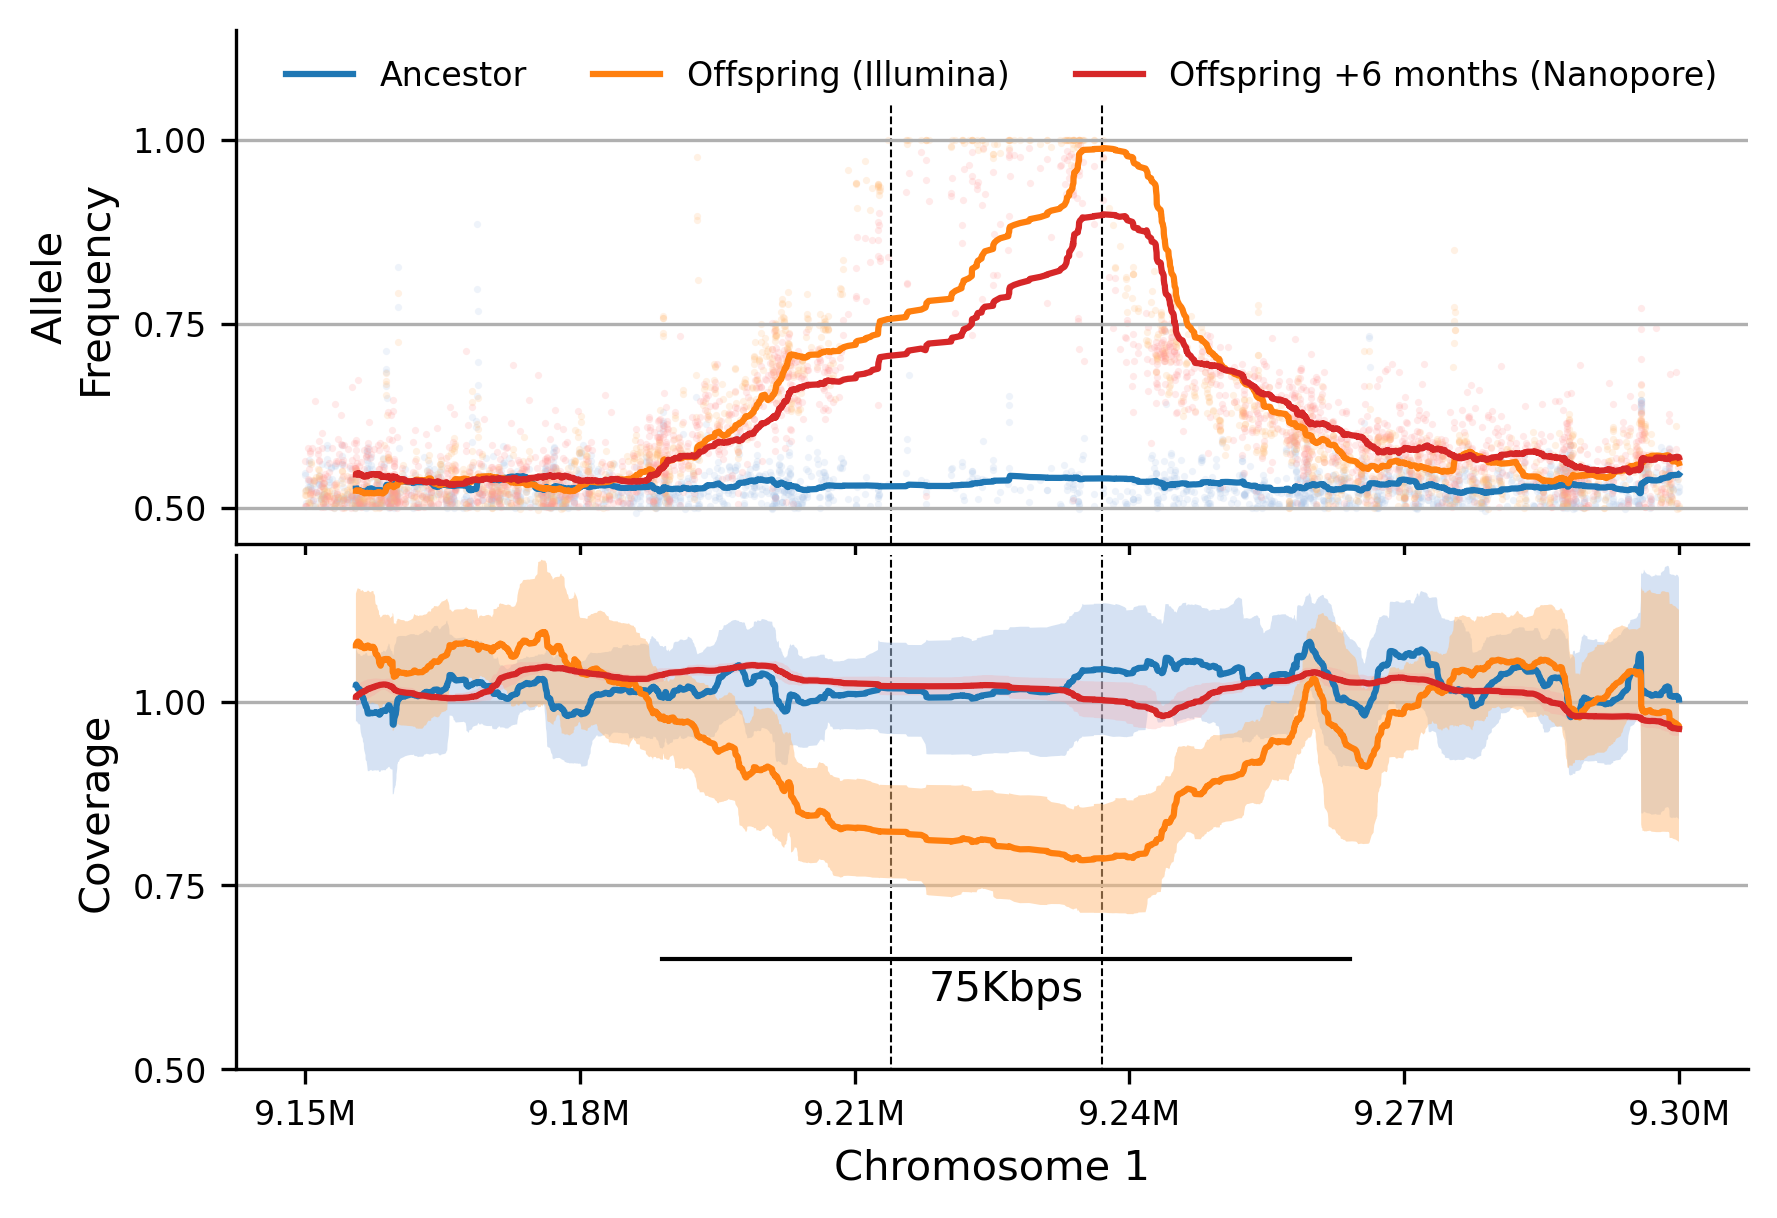

In [61]:
plot_region(
    total_df, "Chrom_1", 9150000, 9300000, bs=9189000, be=9264000, byt=0.65, mincovy=0.5, nbins=100, show_sites=True,
    vlines=[9214000, 9237000],
)

In [62]:
plot_region(total_df, "Chrom_2", 6250000, 6500000, bs=6320000, be=6425000, byt=0.45, mincovy=0.25, show_sites=True,
           vlines=[6335465, 6394000], show_af_df=False)

Left gradual = 15.465 Kb
Right gradual = 31.000 Kb


Left gradual = 22.999 Kb
Right gradual = 33.000 Kb


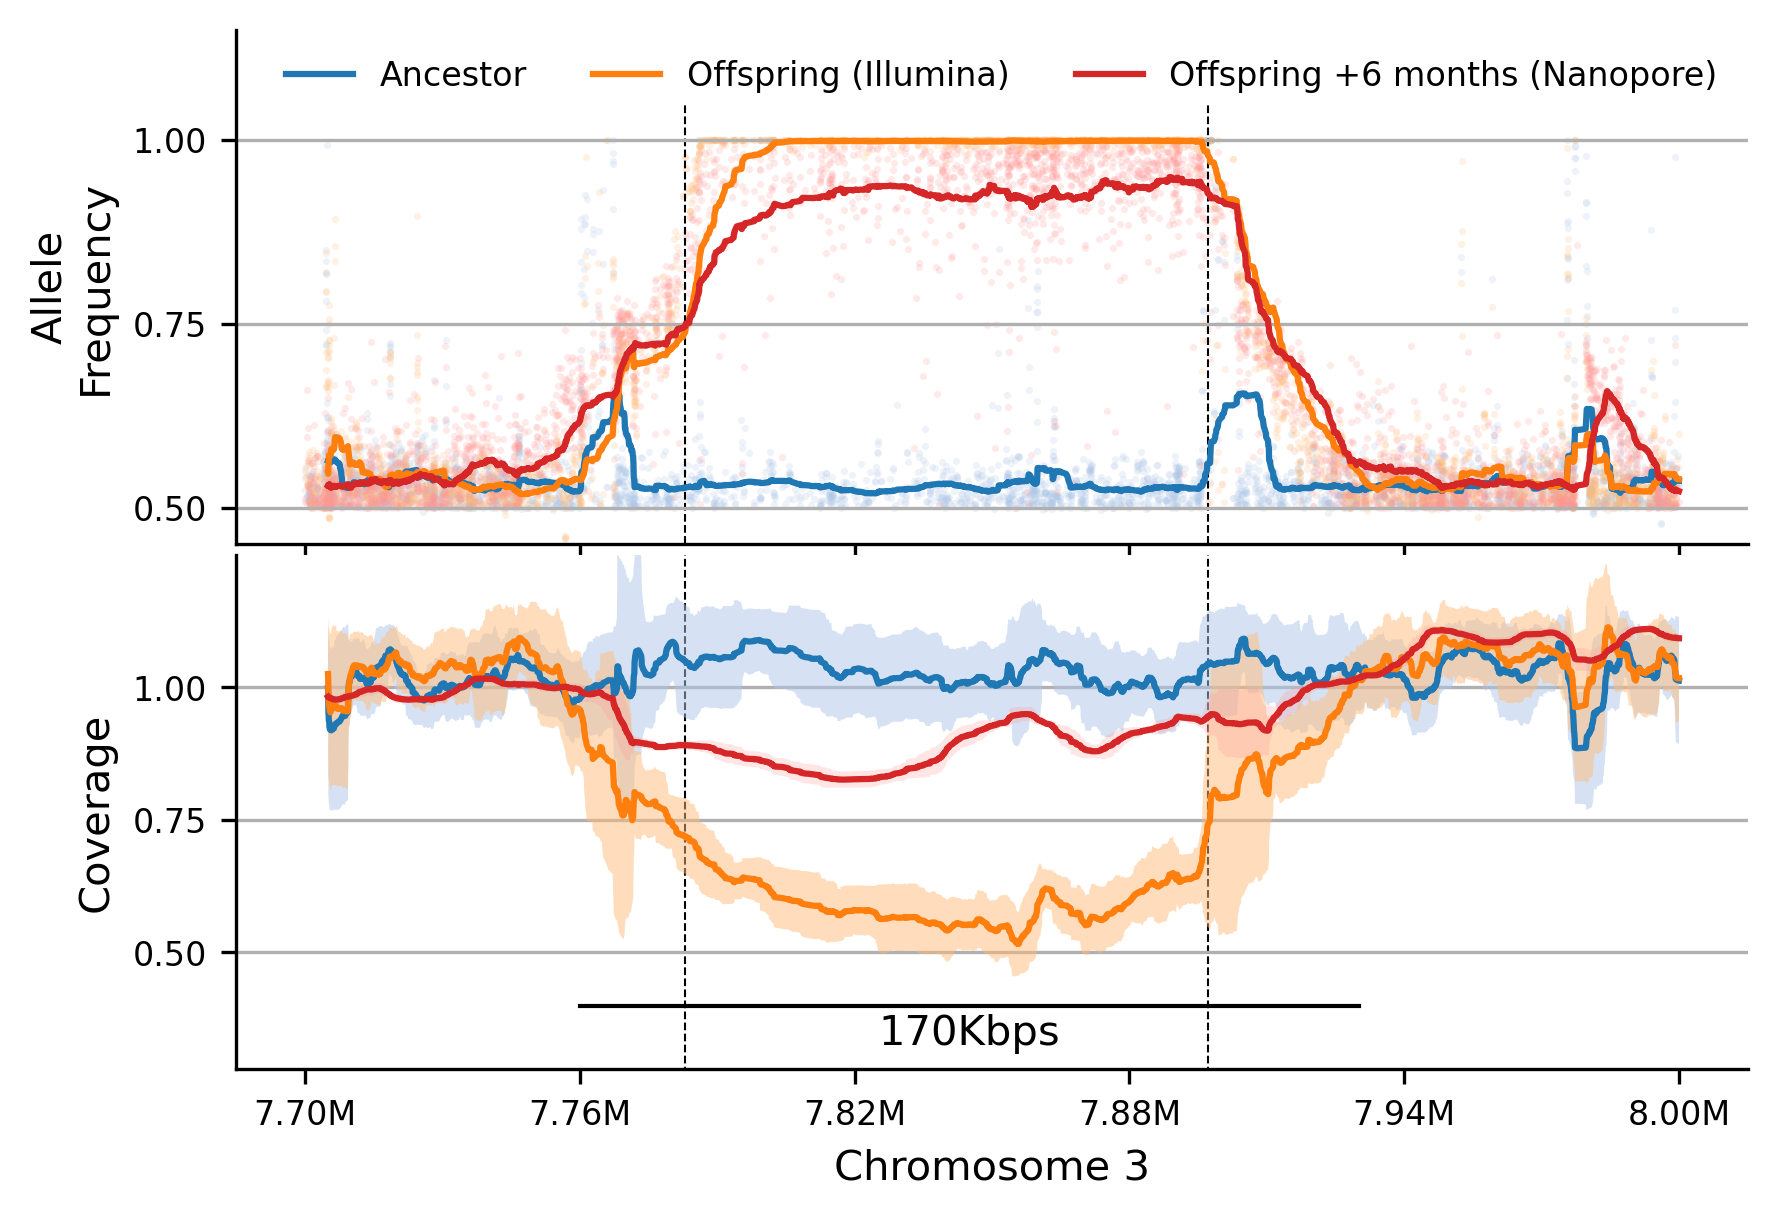

In [63]:
plot_region(total_df, "Chrom_3", 7700000, 8000000, bs=7760000, be=7930000, byt=0.4, mincovy=0.28, maxcovy=1.25, show_sites=True,
           vlines=[7782999, 7897000], show_af_df=False)

Left gradual = 25.798 Kb
Right gradual = 33.716 Kb


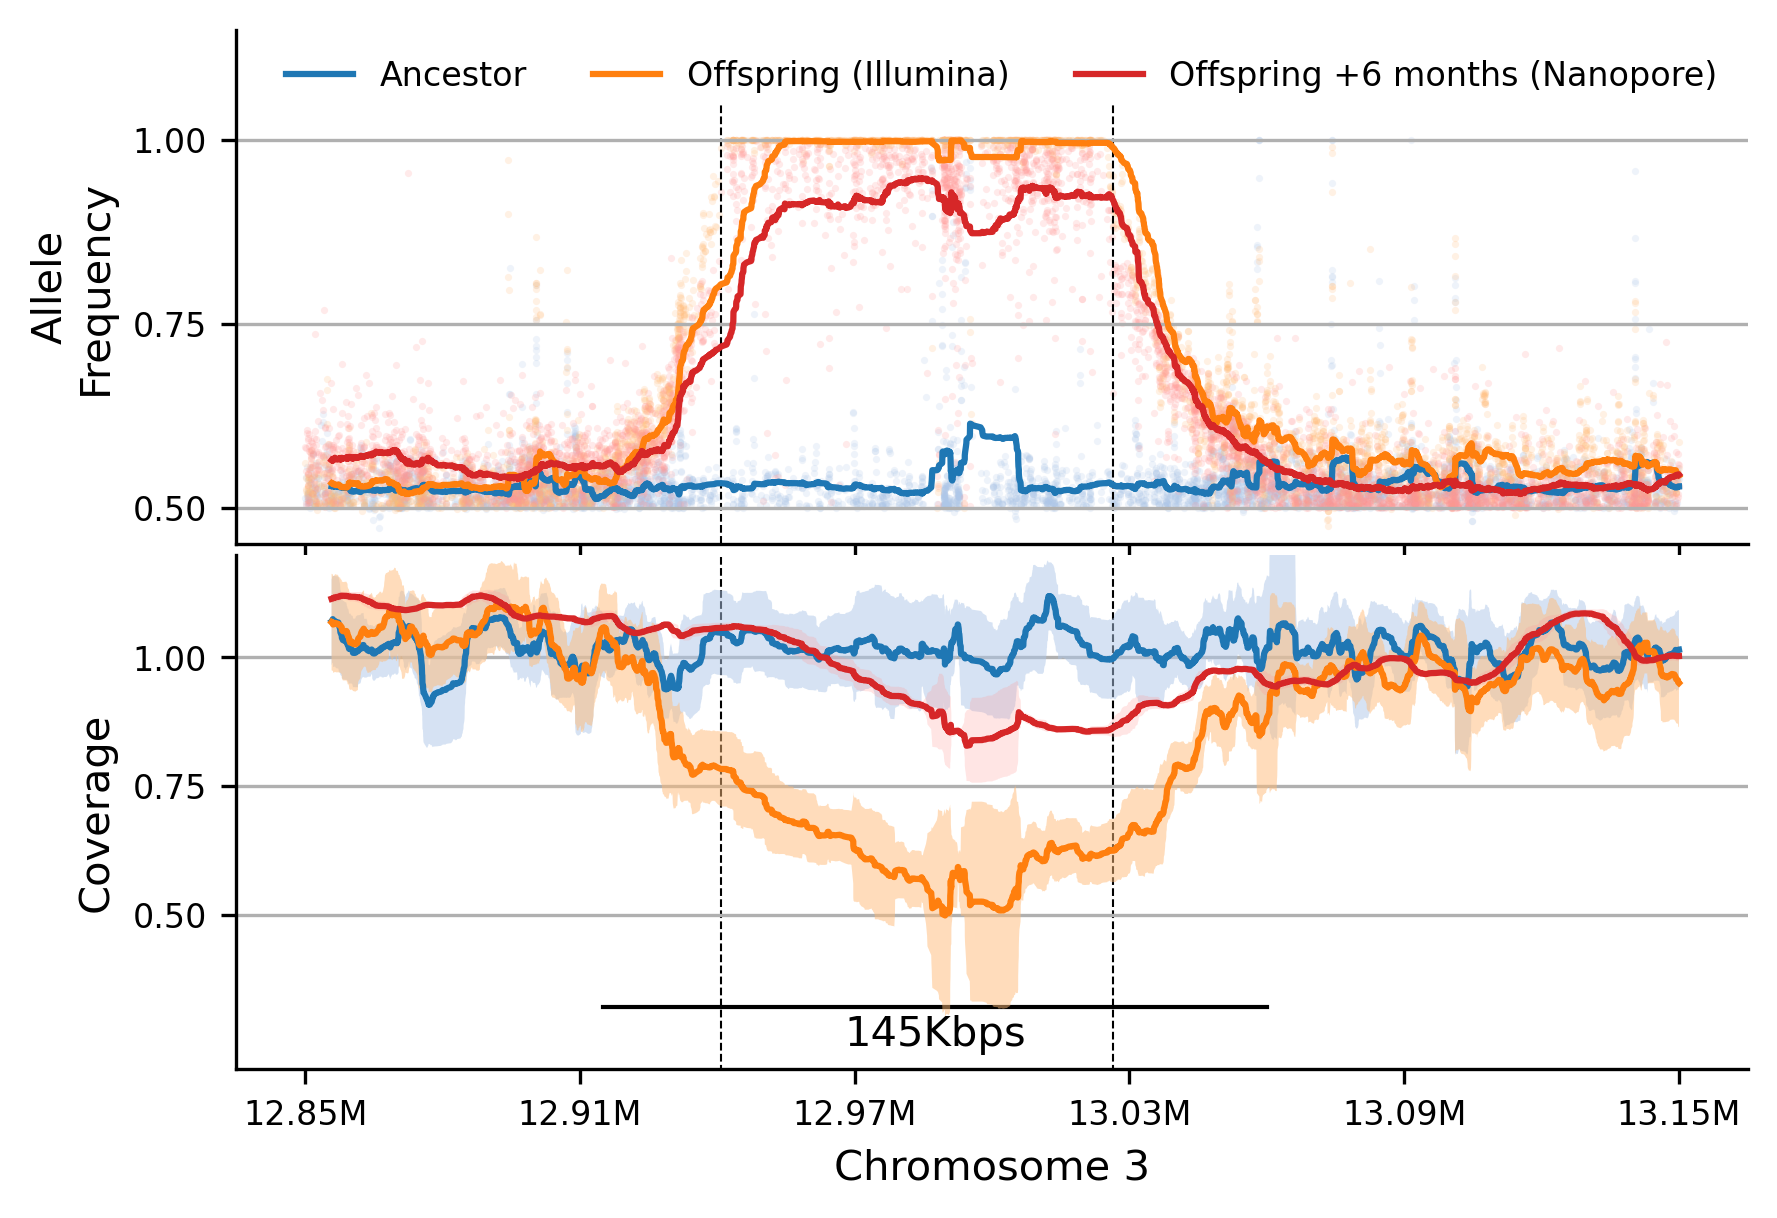

In [64]:
plot_region(total_df, "Chrom_3", 12850000, 13150000, bs=12915000, be=13060000, byt=0.32, mincovy=0.2, show_sites=True,
           vlines=[12940798, 13026284], show_af_df=False)

Left gradual = 24.286 Kb
Right gradual = 22.272 Kb


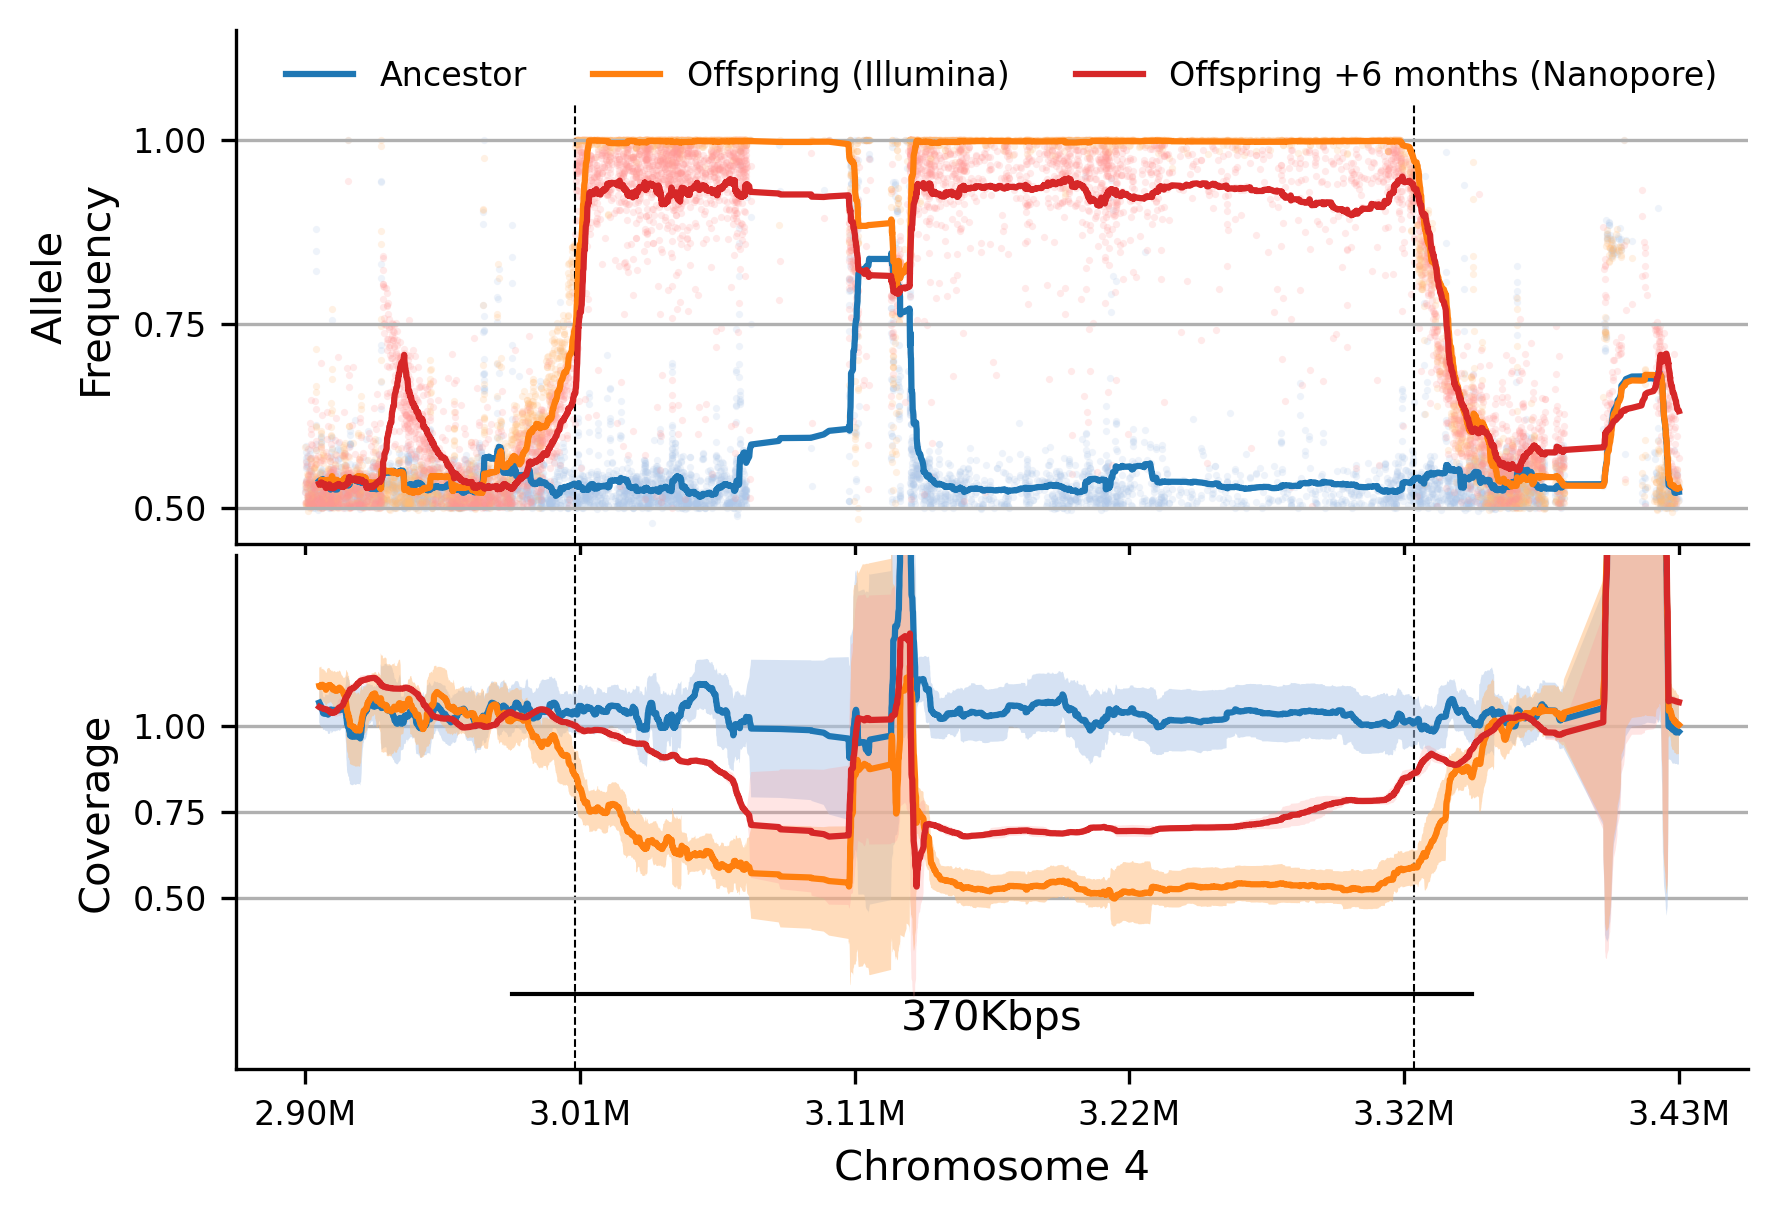

In [65]:
plot_region(total_df, "Chrom_4", 2900000, 3430000, bs=2980000, be=3350000, byt=0.22, mincovy=0.0, maxcovy=1.5, show_sites=True,
           vlines=[3004286, 3327728], show_af_df=False)

Left gradual = 32.869 Kb
Right gradual = 22.535 Kb


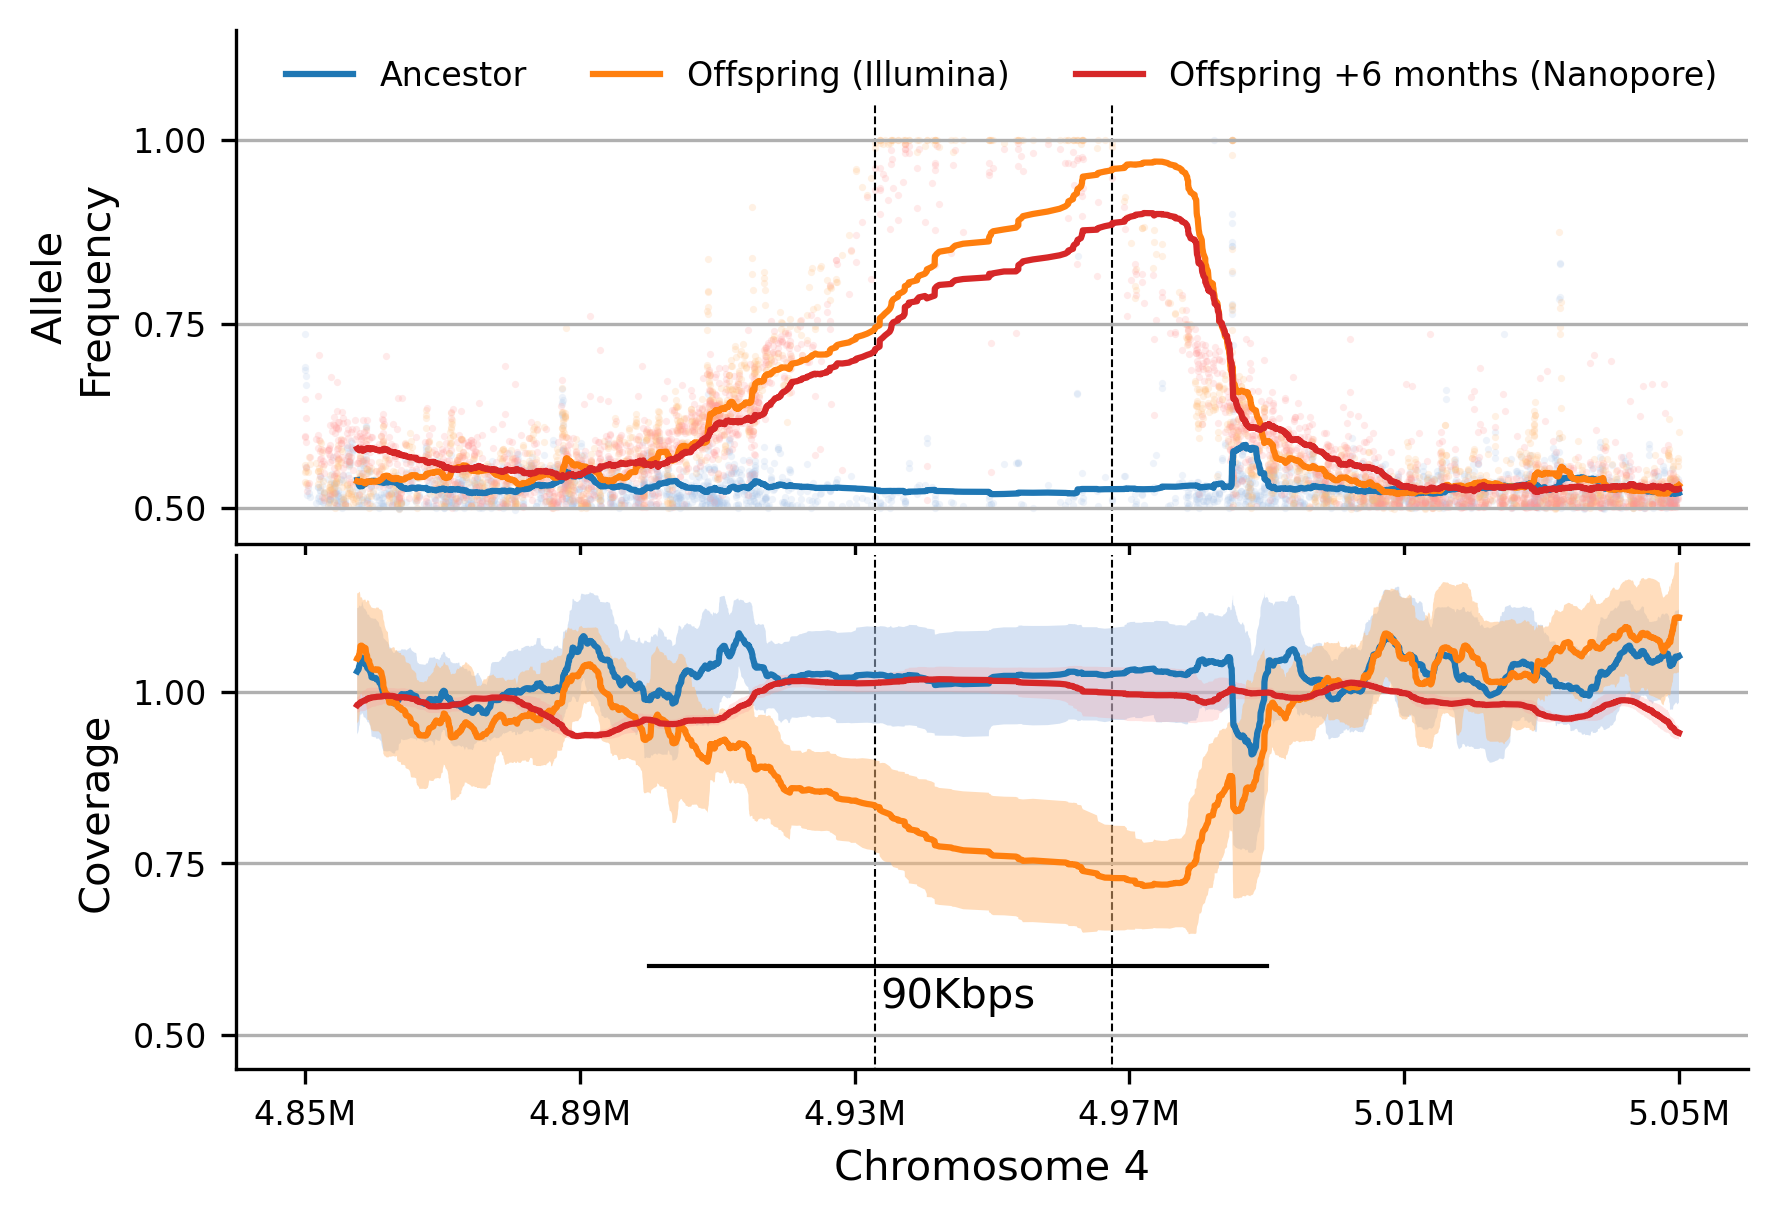

In [66]:
plot_region(total_df, "Chrom_4", 4850000, 5050000, bs=4900000, be=4990000, byt=0.6, mincovy=0.45, show_sites=True,
           vlines=[4932869, 4967465], show_af_df=False)

Left gradual = 35.176 Kb
Right gradual = 26.485 Kb


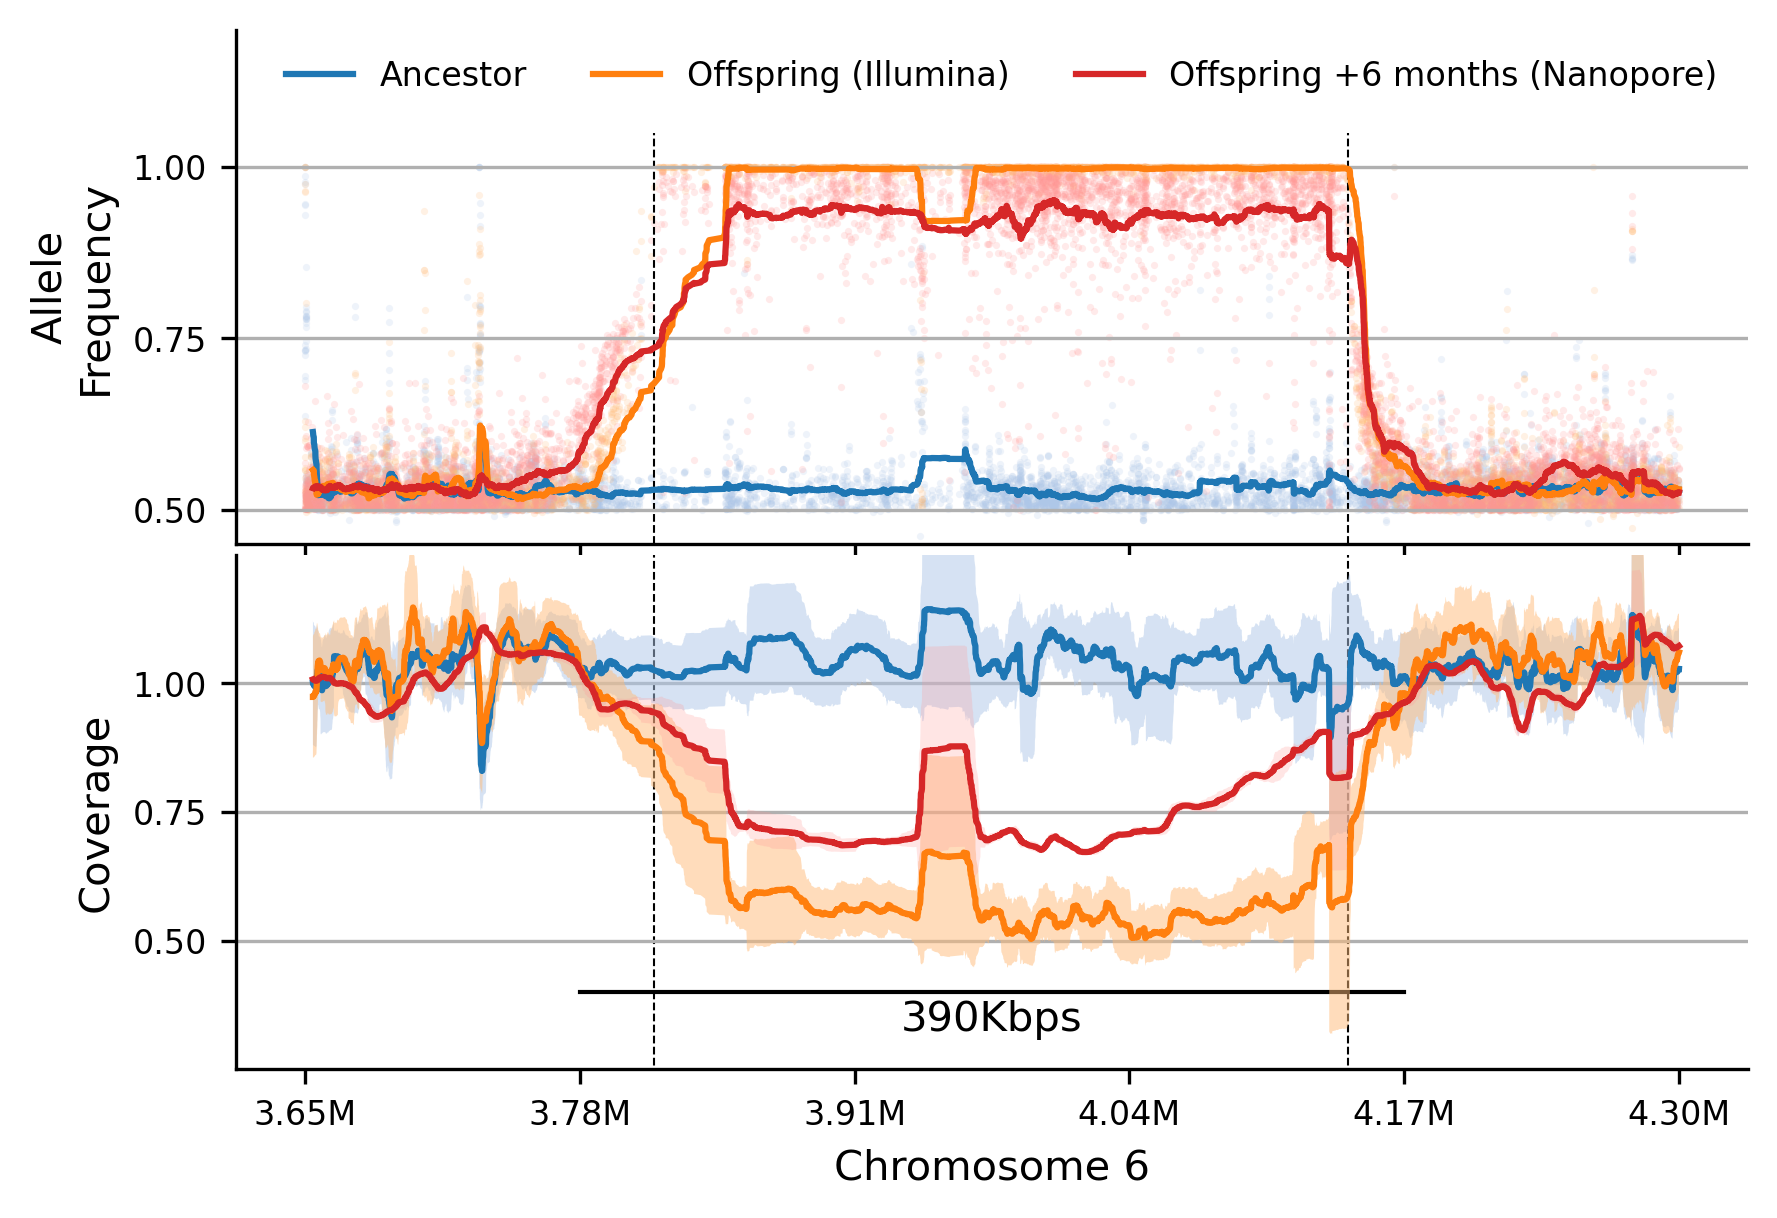

In [67]:
plot_region(total_df, "Chrom_6", 3650000, 4300000, bs=3780000, be=4170000, byt=0.4, mincovy=0.25, maxcovy=1.25, mafy=1.2, show_sites=True,
           vlines=[3815176, 4143515], show_af_df=False)

CHROM       POS       AAF       IAF       OAF
100044779  Chrom_6  13113178  1.000000  1.000000  0.937656
100054582  Chrom_6  13122981  0.791139  1.000000  0.836983
100119504  Chrom_6  13187903  0.637795  0.973485  0.833747
100120193  Chrom_6  13188592  0.527132  0.976000  0.833760
100120371  Chrom_6  13188770  0.520325  0.969231  0.875325
...            ...       ...       ...       ...       ...
100461470  Chrom_6  13529869  0.833333  1.000000  0.954545
100461566  Chrom_6  13529965  0.666667  1.000000  1.000000
100461570  Chrom_6  13529969  0.666667  1.000000  0.984375
100461586  Chrom_6  13529985  0.600000  1.000000  0.910448
100461587  Chrom_6  13529986  0.600000  1.000000  0.940299

[4886 rows x 5 columns]

Left gradual = 0.000 Kb
Right gradual = 0.000 Kb


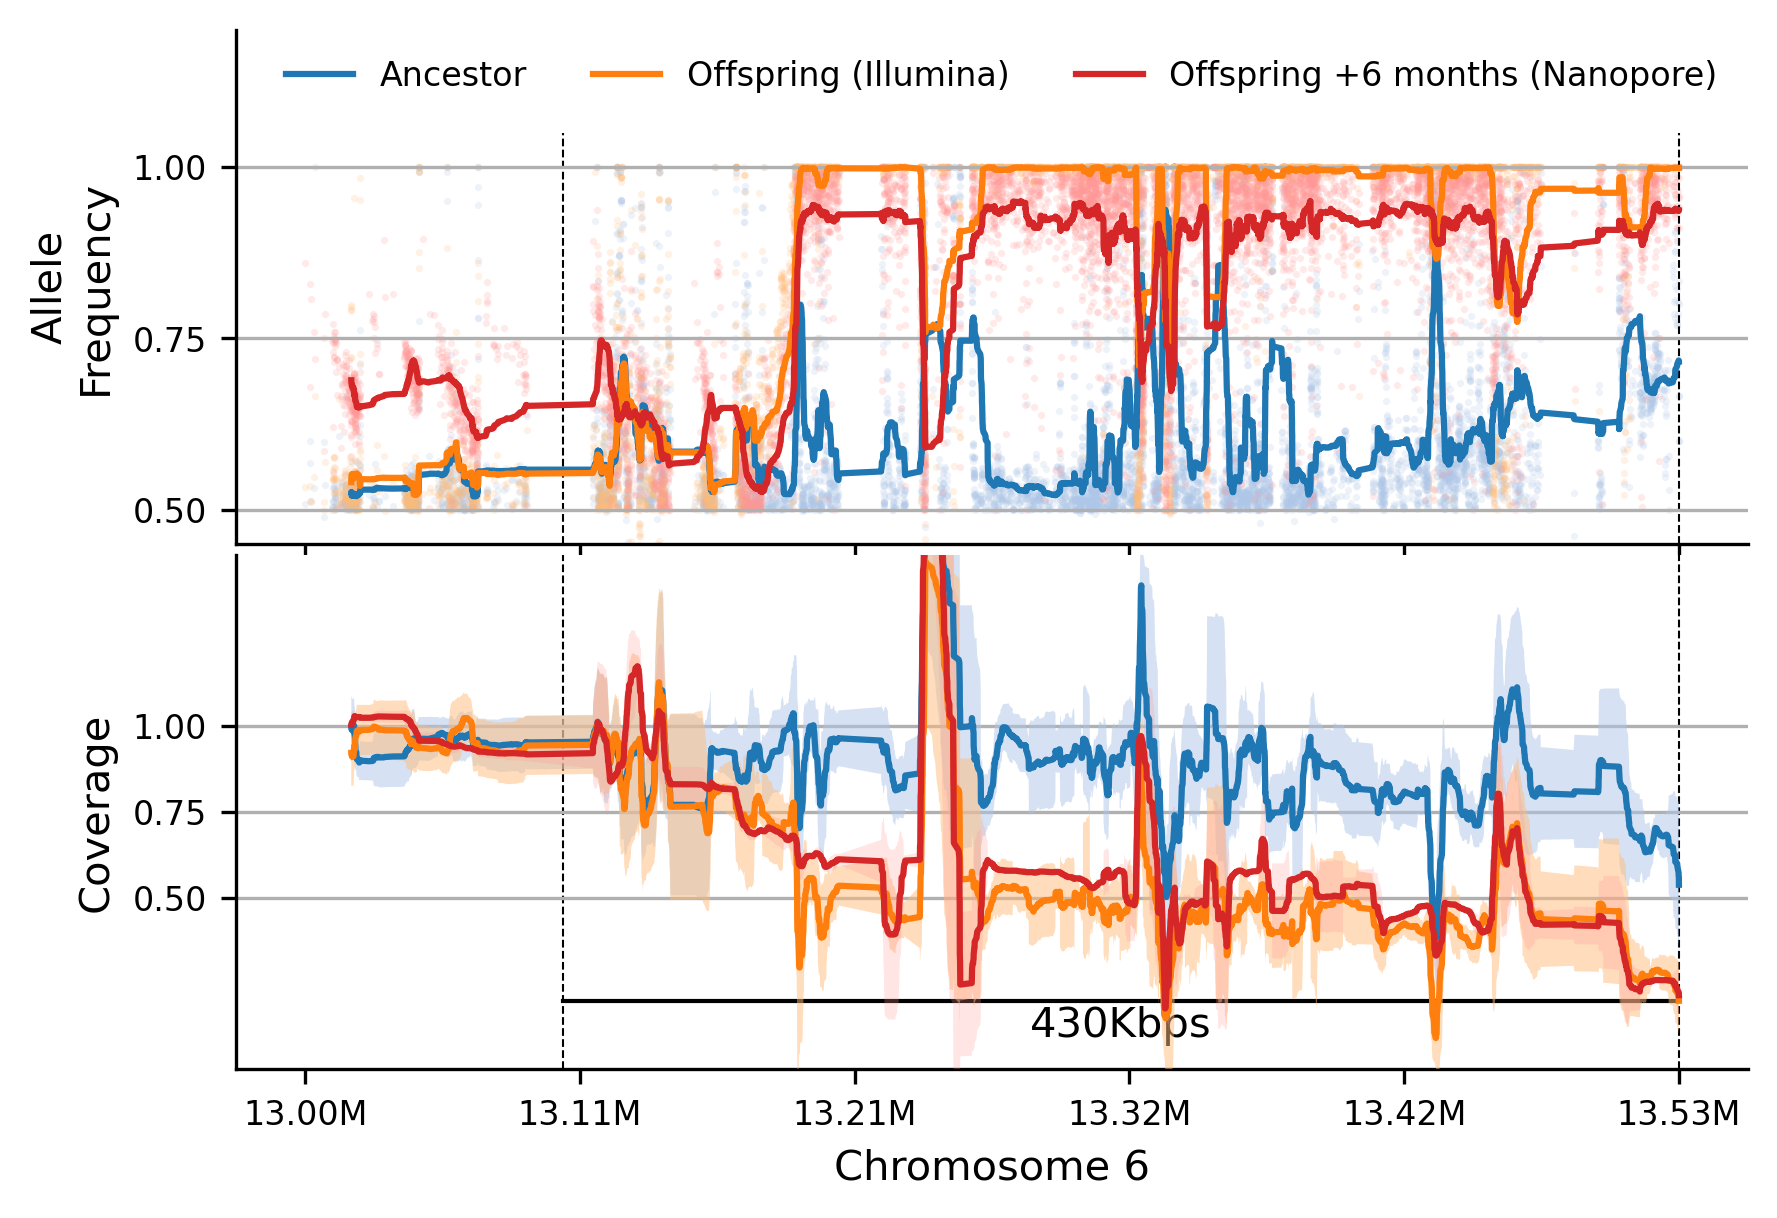

In [68]:
plot_region(total_df, "Chrom_6", 13000000, 13530000, bs=13100000, be=13530000, byt=0.2, mincovy=0.0, maxcovy=1.5, mafy=1.2, min_qual=20, show_sites=True,
           vlines=[13100000, 13530000], show_af_df=True)

# Coverage change over time

In [71]:
def get_data_coverage_evolution(deletions, mac, mt0, mt1) :

    evol_data = {"chrom":[], "size":[], "cac":[], "ct0":[], "ct1":[]}
    
    for coord in deletions :
        ctg, start, end = coord[0], coord[1], coord[2]
        data = total_df.query("CHROM == @ctg & POS >= @start & POS <= @end")
        
        cov_ac = data["COV_ANC"].div(mac).mean()
        cov_t0 = data["COV_ILU"].div(mt0).mean()
        cov_t1 = data["COV_ONT"].div(mt1).mean()
        
        evol_data["chrom"].append(ctg)
        evol_data["size"].append(np.log10(end-start))
        evol_data["cac"].append(cov_ac)
        evol_data["ct0"].append(cov_t0)
        evol_data["ct1"].append(cov_t1)
    
    return evol_data

In [72]:
mean_ac = 341 # actually median coverage from notebook 04
mean_t0 = 291
mean_t1 = 960

deletions = [
    ("Chrom_1", 7050000, 7365000),
    ("Chrom_1", 9189000, 9264000),
    ("Chrom_2", 6320000, 6425000),
    ("Chrom_3", 7760000, 7930000),
    ("Chrom_3", 12915000, 13060000),
    ("Chrom_4", 2980000, 3350000),
    ("Chrom_4", 4900000, 4990000),
    ("Chrom_6", 3780000, 4170000),
    #("Chrom_6", 13100000, 13530000),
]

data = get_data_coverage_evolution(deletions, mean_ac, mean_t0, mean_t1)

In [73]:
del_evol_data_df = pd.DataFrame().from_dict(data)
del_evol_data_df

chrom      size       cac       ct0       ct1
0  Chrom_1  5.498311  1.022421  0.631764  0.867669
1  Chrom_1  4.875061  1.030467  0.863613  1.018329
2  Chrom_2  5.021189  1.015851  0.762180  0.940046
3  Chrom_3  5.230449  1.029093  0.680846  0.906451
4  Chrom_3  5.161368  1.019427  0.707890  0.950901
5  Chrom_4  5.568202  0.949261  0.586720  0.774362
6  Chrom_4  4.954243  1.029360  0.807637  0.991483
7  Chrom_6  5.591065  1.033999  0.627934  0.780479

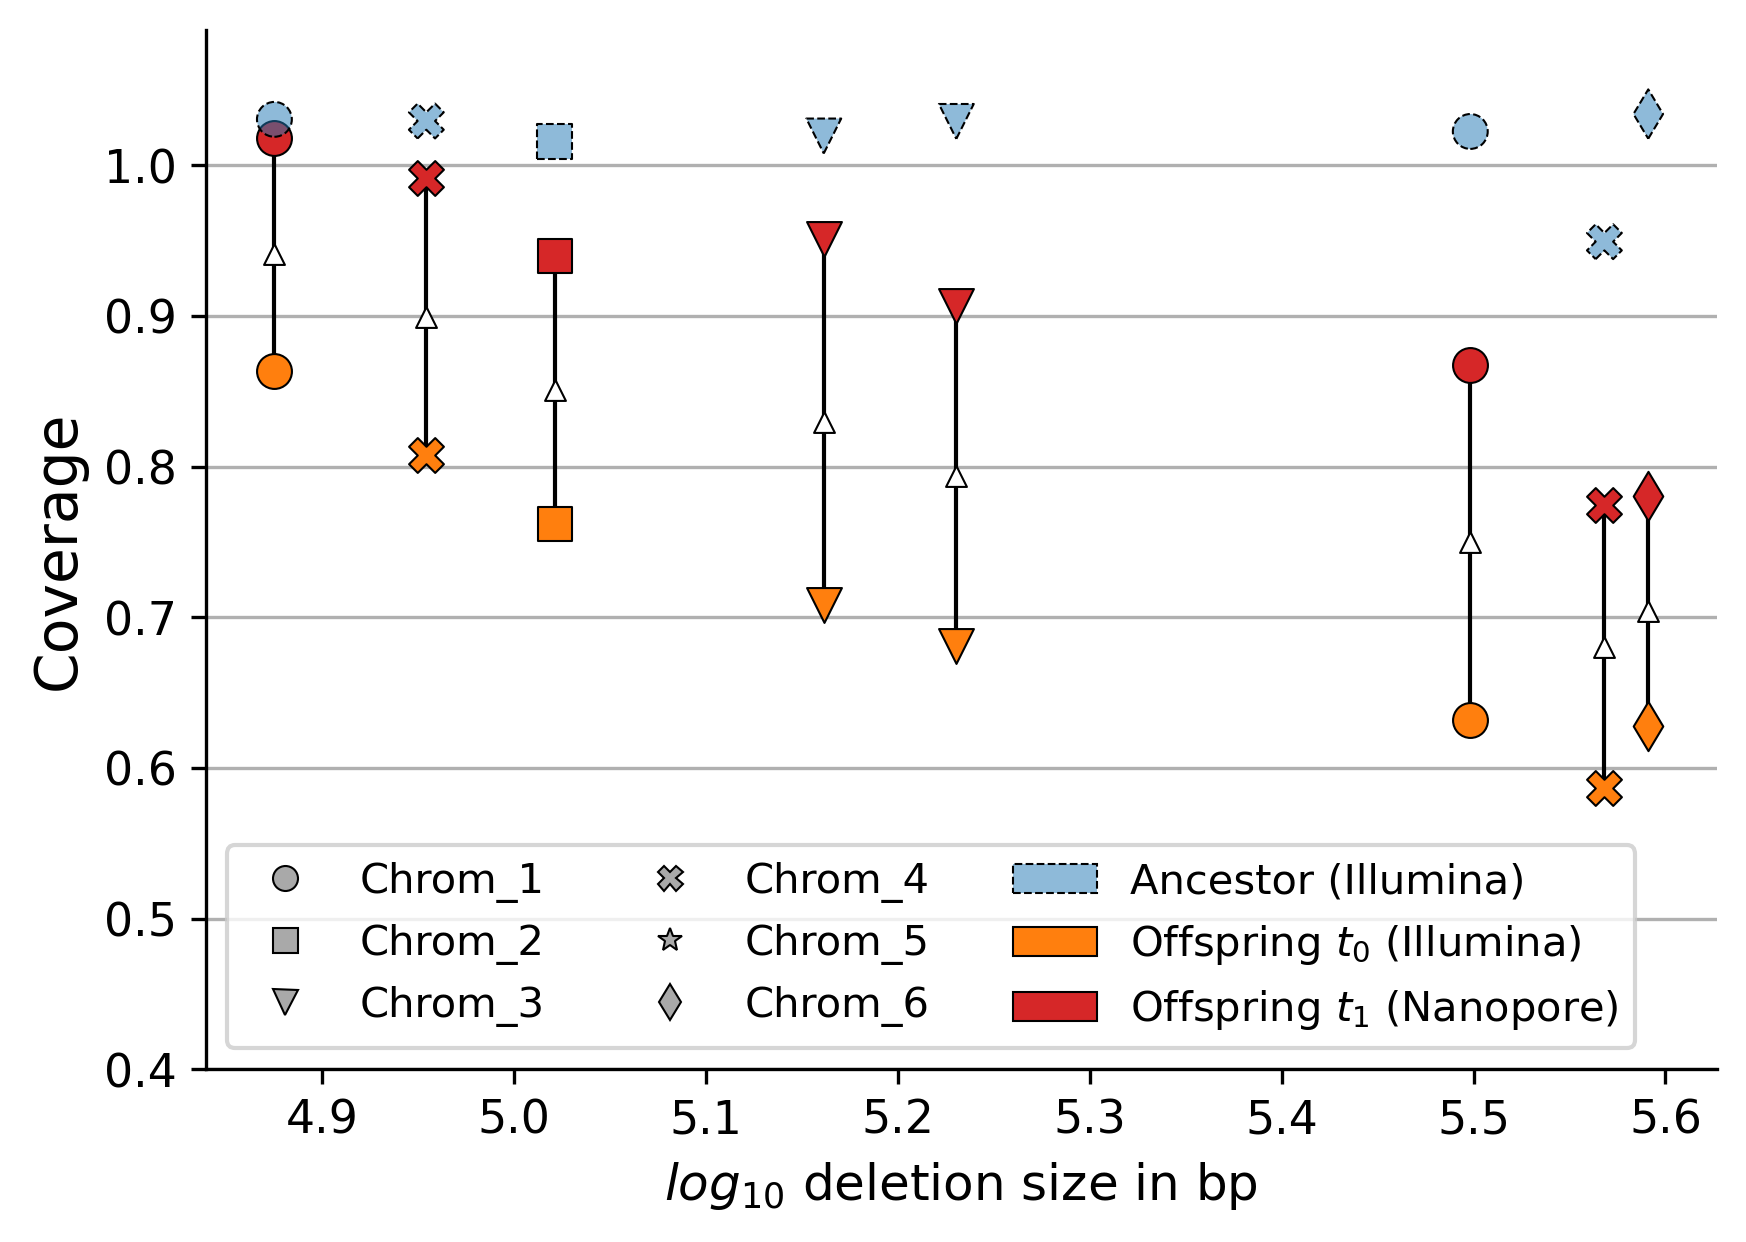

In [75]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

markers = {
    "Chrom_1":"o",
    "Chrom_2":"s",
    "Chrom_3":"v",
    "Chrom_4":"X",
    "Chrom_5":"*",
    "Chrom_6":"d",    
}

fig, ax = plt.subplots(figsize=(6.5,4.5))

for i, row in del_evol_data_df.iterrows() :
    
    # Ancestor (for reference)
    ax.scatter([row["size"]], [row["cac"]], marker=markers[row["chrom"]], facecolor=cycle[0]+"80", s=70, lw=0.5, ec="k", linestyle="dashed", zorder=10)
    # t0
    ax.scatter([row["size"]], [row["ct0"]], marker=markers[row["chrom"]], facecolor=cycle[1], s=70, lw=0.5, ec="k", zorder=6)
    # t1
    ax.scatter([row["size"]], [row["ct1"]], marker=markers[row["chrom"]], facecolor=cycle[3], s=70, lw=0.5, ec="k", zorder=6)
    
    #t0 = deletion_df_p500_c18_e3.iloc[i]
    #t1 = deletion_df_p500_c18_e3_ont.iloc[i]
    
    #ax.scatter(t0["logsize"], t0["norm_off_depth"], marker=markers[t0["chrom"]], color=cycle[0], s=70, lw=0.5, ec="k", zorder=5)
    #ax.scatter(t1["logsize"], t1["norm_off_depth"], marker=markers[t1["chrom"]], color=cycle[1], s=70, lw=0.5, ec="k", zorder=5)
    
    if row["ct1"] > row["ct0"] :
        mid = row["ct1"]-abs(row["ct1"]-row["ct0"])/2
        ax.scatter([row["size"]], [mid], marker="^", fc="white", ec="k", lw=0.5, s=25, zorder=5)
    else :
        mid = row["ct0"]-abs(row["ct0"]-row["ct1"])/2
        ax.scatter(row["size"], [mid], marker="v", fc="white", ec="k", lw=0.5, s=25, zorder=5)
    
    ax.plot([row["size"], row["size"]], [row["ct0"], row["ct1"]], marker=None, color="k", lw=1.0, zorder=2)
    
ax.set_xlabel(r"$log_{10}$ deletion size in bp", fontsize=12)
ax.set_ylabel("Coverage", fontsize=14)

#ax.set_title("GR - 500Gy IR - P500 C18 E3 - Deletion coverage change over time", fontsize=10)

ax.grid(axis="y", zorder=1)

ax.set_ylim(0.4,1.09)

legend_elements = [Line2D([0], [0], marker=m, mew=0.5, lw=0.0, mec="k", mfc="darkgrey", label=c) for c, m in markers.items()]
legend_elements += [
    Patch(facecolor=cycle[0]+"80", lw=0.5, linestyle="dashed", ec="k", label=r"Ancestor (Illumina)"),
    Patch(facecolor=cycle[1], lw=0.5, ec="k", label=r"Offspring $t_{0}$ (Illumina)"),
    Patch(facecolor=cycle[3], lw=0.5, ec="k", label=r"Offspring $t_{1}$ (Nanopore)")
]

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize=11)
ax.legend(handles=legend_elements, loc="lower left", fontsize=10, ncol=3)

plt.show()

### Coverage evolution correlation with size

In [17]:
# Original state value = ancestor value
del_evol_data_df = del_evol_data_df.assign(nac=del_evol_data_df["cac"]/del_evol_data_df["cac"])
del_evol_data_df = del_evol_data_df.assign(nt0=del_evol_data_df["ct0"]/del_evol_data_df["cac"])
del_evol_data_df = del_evol_data_df.assign(nt1=del_evol_data_df["ct1"]/del_evol_data_df["cac"])
del_evol_data_df = del_evol_data_df.assign(delta=((del_evol_data_df["nt1"]-del_evol_data_df["nt0"]))*100)
del_evol_data_df = del_evol_data_df.sort_values(by="size")
del_evol_data_df

chrom      size       cac       ct0       ct1  nac       nt0       nt1  \
1  Chrom_1  4.875061  1.030467  0.863613  1.018329  1.0  0.838079  0.988221   
6  Chrom_4  4.954243  1.029360  0.807637  0.991483  1.0  0.784601  0.963203   
2  Chrom_2  5.021189  1.015851  0.762180  0.940046  1.0  0.750287  0.925378   
4  Chrom_3  5.161368  1.019427  0.707890  0.950901  1.0  0.694400  0.932780   
3  Chrom_3  5.230449  1.029093  0.680846  0.906451  1.0  0.661598  0.880825   
0  Chrom_1  5.498311  1.022421  0.631764  0.867669  1.0  0.617910  0.848641   
5  Chrom_4  5.568202  0.949261  0.586720  0.774362  1.0  0.618081  0.815753   
7  Chrom_6  5.591065  1.033999  0.627934  0.780479  1.0  0.607287  0.754816   

       delta  
1  15.014186  
6  17.860192  
2  17.509047  
4  23.838029  
3  21.922718  
0  23.073077  
5  19.767247  
7  14.752935

In [18]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

markers = {
    "Chrom_1":"o",
    "Chrom_2":"s",
    "Chrom_3":"v",
    "Chrom_4":"X",
    "Chrom_5":"*",
    "Chrom_6":"d",    
}

fig, ax = plt.subplots(figsize=(6.5,4.5))

for i, row in del_evol_data_df.iterrows() :
    
    # Ancestor (for reference)
    ax.scatter([row["size"]], [row["nac"]], marker=markers[row["chrom"]], facecolor=cycle[0]+"80", s=70, lw=0.5, ec="k", linestyle="dashed", zorder=10)
    # t0
    ax.scatter([row["size"]], [row["nt0"]], marker=markers[row["chrom"]], facecolor=cycle[1], s=70, lw=0.5, ec="k", zorder=6)
    # t1
    ax.scatter([row["size"]], [row["nt1"]], marker=markers[row["chrom"]], facecolor=cycle[3], s=70, lw=0.5, ec="k", zorder=6)
    
    #t0 = deletion_df_p500_c18_e3.iloc[i]
    #t1 = deletion_df_p500_c18_e3_ont.iloc[i]
    
    #ax.scatter(t0["logsize"], t0["norm_off_depth"], marker=markers[t0["chrom"]], color=cycle[0], s=70, lw=0.5, ec="k", zorder=5)
    #ax.scatter(t1["logsize"], t1["norm_off_depth"], marker=markers[t1["chrom"]], color=cycle[1], s=70, lw=0.5, ec="k", zorder=5)
    
    if row["nt1"] > row["nt0"] :
        mid = row["nt1"]-abs(row["nt1"]-row["nt0"])/2
        ax.scatter([row["size"]], [mid], marker="^", fc="white", ec="k", lw=0.5, s=25, zorder=5)
    else :
        mid = row["nt0"]-abs(row["nt0"]-row["nt1"])/2
        ax.scatter(row["size"], [mid], marker="v", fc="white", ec="k", lw=0.5, s=25, zorder=5)
    
    ax.plot([row["size"], row["size"]], [row["nt0"], row["nt1"]], marker=None, color="k", lw=1.0, zorder=2)
    
ax.set_xlabel(r"$log_{10}$ deletion size in bp", fontsize=12)
ax.set_ylabel(r"Coverage / Cov$_{Ancestor}$", fontsize=12)

ax.set_title("GR - 500Gy IR - P500 C18 E3 - Deletion coverage change over time", fontsize=10)

ax.grid(axis="y", zorder=1)

ax.set_ylim(0.41,1.09)

legend_elements = [Line2D([0], [0], marker=m, mew=0.5, lw=0.0, mec="k", mfc="darkgrey", label=c) for c, m in markers.items()]
legend_elements += [
    Patch(facecolor=cycle[0]+"80", lw=0.5, linestyle="dashed", ec="k", label=r"Ancestor (Illumina)"),
    Patch(facecolor=cycle[1], lw=0.5, ec="k", label=r"Offspring $t_{0}$ (Illumina)"),
    Patch(facecolor=cycle[3], lw=0.5, ec="k", label=r"Offspring $t_{1}$ (Nanopore)")
]
ax.legend(handles=legend_elements, loc="lower left", fontsize=10, ncol=3)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(labelsize=8)


plt.show()

# GR Complex Deletions in P500 C30 E3 (Chrom 2 and 5)

In [7]:
cov_anc = pd.read_csv(
    "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/coverage/ancestor.sorted.CALL.bam.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_anc = cov_anc.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ANC"})

In [8]:
cov_ilu = pd.read_csv(
    "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/coverage/P500_C30_E3.sorted.CALL.bam.cov.gz",
    sep="\t", compression="gzip", usecols=range(3), names=["ref", "pos", "cov"], header=None, skiprows=1,
)

cov_ilu = cov_ilu.rename(columns={"ref":"CHROM", "pos":"POS", "cov":"COV_ILU"})

In [9]:
print("mean:", cov_ilu["COV_ILU"].mean())
print("median:", cov_ilu["COV_ILU"].median())
print("mode:", cov_ilu.query("COV_ILU > 0")["COV_ILU"].mode().iloc[0])

mean: 261.2567500635855
median: 275.0
mode: 284


In [10]:
def parse_region_illu_only(input_illumina, ancestor, sample, chrom, start, end) :
    
    dc = {
        "CHROM":[], "POS":[], "QUAL":[], "ALS":[], # general
        "AAL":[], "ADP":[], "AAD":[], "AAF":[], # ancestor
        "IAL":[], "IDP":[], "IAD":[], "IAF":[], "IGT":[], # illumina offspring
    }
    
    # Parse variant file
    vcf_in = VariantFile(input_illumina)  # auto-detect input format
    vcf_in.subset_samples([ancestor, sample])
    
    # For record in sample
    for rec in vcf_in.fetch(chrom, start, end) :
        
        dc["CHROM"].append(rec.chrom)
        dc["POS"].append(rec.pos)
        dc["AAL"].append([al for n, al in enumerate(rec.alleles) if n in rec.samples[ancestor]["GT"]])
        dc["IAL"].append([al for n, al in enumerate(rec.alleles) if n in rec.samples[sample]["GT"]])
        dc["QUAL"].append(rec.qual)
        
        dc["ALS"].append(rec.alleles)
        
        try :
            dc["IGT"].append(rec.samples[sample]["GT"])
        except :
            dc["IGT"].append(None)
        
        try :
            dc["ADP"].append(rec.samples[ancestor]["DP"])
        except :
            dc["ADP"].append(None)
        try :
            dc["IDP"].append(rec.samples[sample]["DP"])
        except :
            dc["IDP"].append(None)
        
        try :
            dc["AAD"].append(rec.samples[ancestor]["AD"])
            try :
                dc["AAF"].append(max(rec.samples[ancestor]["AD"])/rec.samples[ancestor]["DP"])
            except :
                dc["AAF"].append(None)
        except :
            dc["AAD"].append(None)
            dc["AAF"].append(None)
        
        try :
            dc["IAD"].append(rec.samples[sample]["AD"])
            try :
                dc["IAF"].append(max(rec.samples[sample]["AD"])/rec.samples[sample]["DP"])
            except :
                dc["IAF"].append(None)
        except :
            dc["IAD"].append(None)
            dc["IAF"].append(None)
        
    vcf_in.close()
    df_illu = pd.DataFrame.from_dict(dc)
    
    return df_illu

### Chrom 2 7.3 to 8.9Mbps

In [11]:
vcf_GR = "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/jointgenotyping/merged.only_het.gets.bcf"
df_illu = parse_region_illu_only(vcf_GR, "ancestor", "P500_C30_E3", "Chrom_2", start=7300000, end=8900000)
total_df = pd.merge(df_illu, cov_anc, on=["CHROM", "POS"], how="inner")
total_df = pd.merge(total_df, cov_ilu, on=["CHROM", "POS"], how="inner")

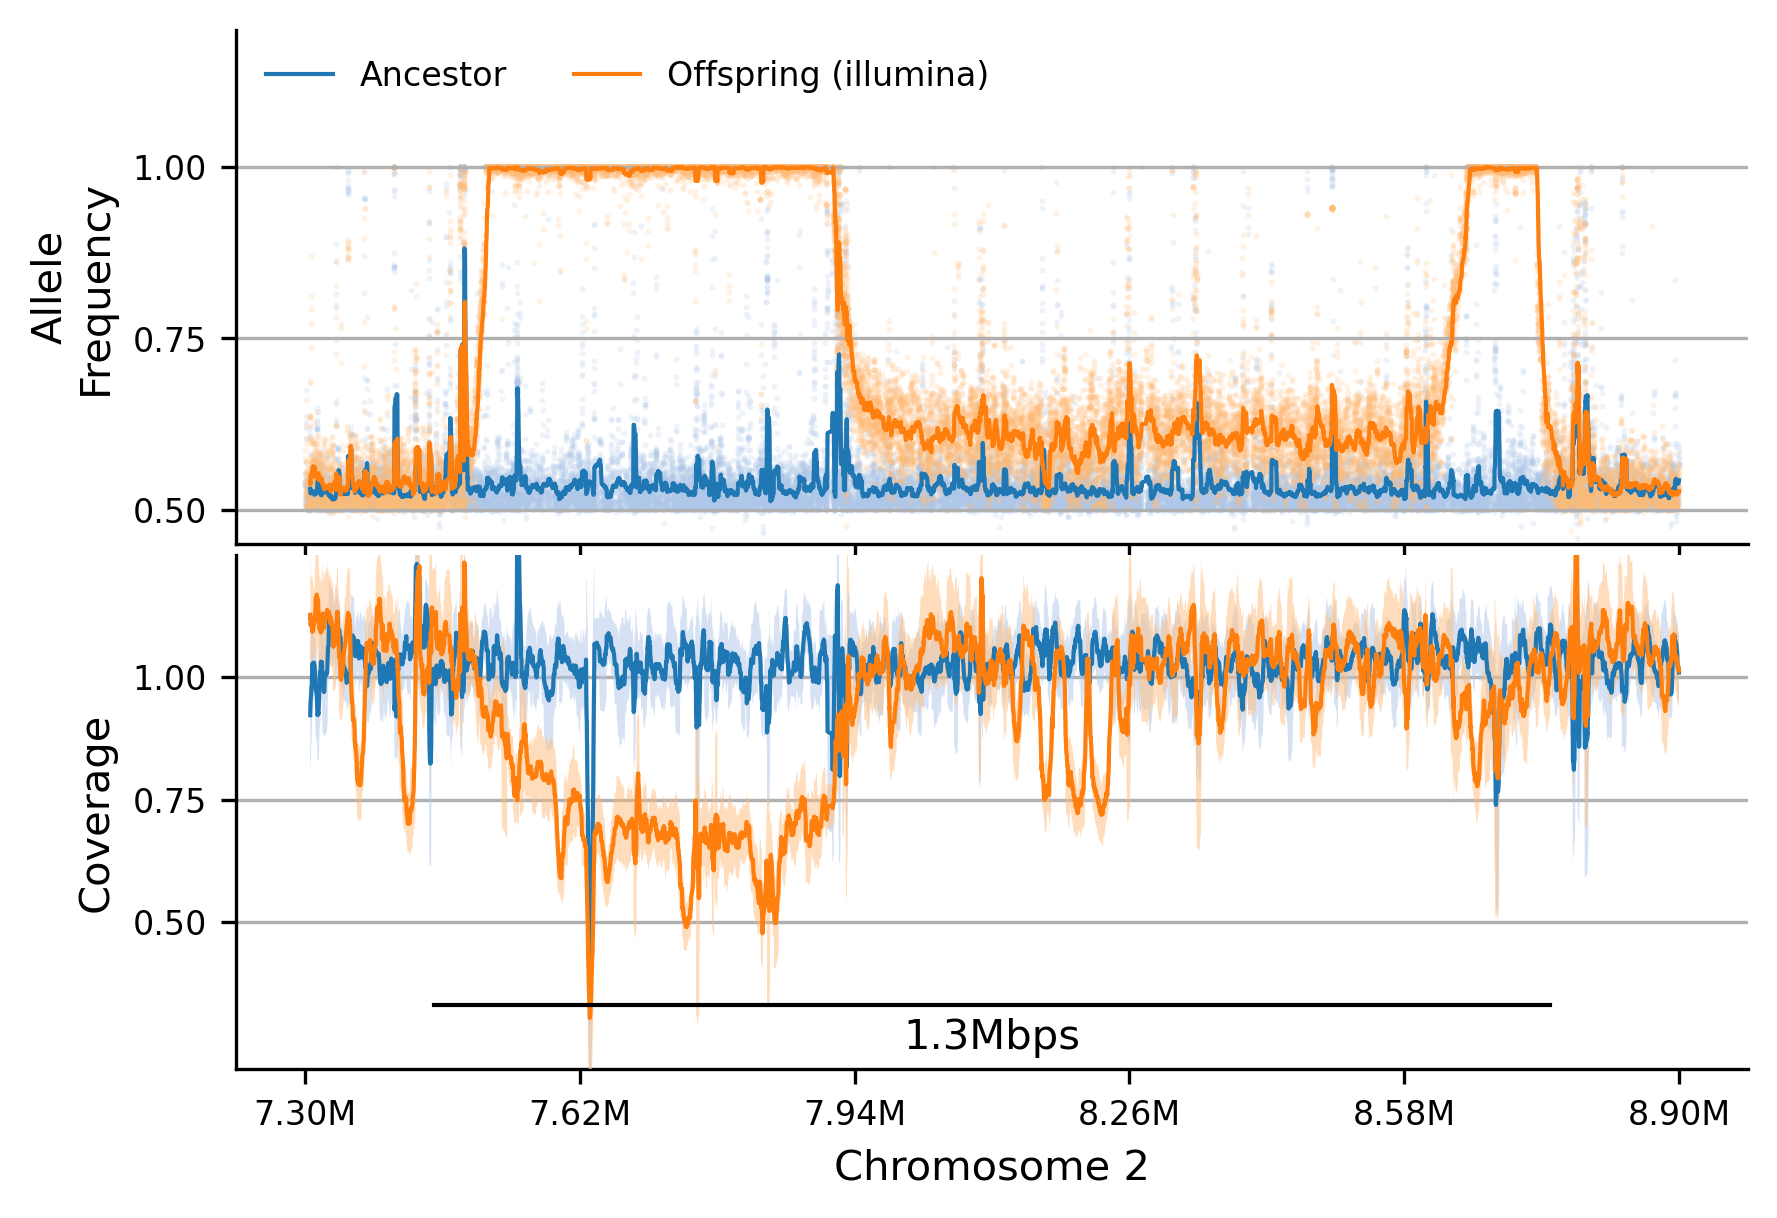

In [18]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6.5,4.5))

flt = total_df.query("POS > 7300000 & POS < 8900000 & QUAL >= 1000")
flt = flt.dropna()

ax = axs[0]

AAF = flt["AAF"].rolling(window=100).mean()
AAF_std = flt["AAF"].rolling(window=100).std()
IAF = flt["IAF"].rolling(window=100).mean()
IAF_std = flt["IAF"].rolling(window=100).std()

ax.scatter(flt["POS"], flt["AAF"], s=2, facecolor=colors[1]+[0.2], ec="k", lw=0.0, zorder=1)
ax.plot(flt["POS"], AAF, color=colors[0], lw=1.0, zorder=15, label="Ancestor")
#ax.fill_between(flt["POS"], AAF+AAF_std, AAF-AAF_std, facecolor=colors[1]+[0.5], zorder=10)

ax.scatter(flt["POS"], flt["IAF"], s=2, facecolor=colors[3]+[0.2], ec="k", lw=0.0, zorder=1)
ax.plot(flt["POS"], IAF, color=colors[2], lw=1.0, zorder=15, label="Offspring (illumina)")
#ax.fill_between(flt["POS"], IAF+IAF_std, IAF-IAF_std, facecolor=colors[3]+[0.5], zorder=10)

ax.yaxis.grid(True, zorder=1)
ax.set_ylim(0.45, 1.2)
ax.set_yticks([0.5, 0.75, 1.0])
ax.tick_params(labelsize=8)
ax.set_ylabel("Allele\nFrequency", fontsize=10)
ax.legend(ncol=3, fontsize=8, frameon=False, loc="upper left")

# Coverage
ax = axs[1]

ADP_scaled = flt["COV_ANC"]/341
Arol = ADP_scaled.rolling(window=100).mean()
Arol_std = ADP_scaled.rolling(window=100).std()

IDP_scaled = flt["COV_ILU"]/275
Irol = IDP_scaled.rolling(window=100).mean()
Irol_std = IDP_scaled.rolling(window=100).std()

ax.plot(flt["POS"], Arol, color=colors[0], lw=1.0, zorder=15, label="Ancestor")
ax.fill_between(flt["POS"], Arol+Arol_std, Arol-Arol_std, facecolor=colors[1]+[0.5], zorder=10)

ax.plot(flt["POS"], Irol, color=colors[2], lw=1.0, zorder=15, label="Offspring (illumina)")
ax.fill_between(flt["POS"], Irol+Irol_std, Irol-Irol_std, facecolor=colors[3]+[0.5], zorder=10)

ax.yaxis.grid(True, zorder=1)
ax.set_ylim(0.2, 1.25)
ax.set_yticks([0.5, 0.75, 1.0])
ax.tick_params(labelsize=8)
ax.set_ylabel("Coverage", fontsize=10)

start = min(flt["POS"])
end = max(flt["POS"])
ticks = np.linspace(start, end, 6)
ticklabels = []
for t in ticks :
    ticklabels.append("{:.2f}M".format(round(t/1000000, 2)))
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, fontsize=8) #, fontsize=12)
ax.set_xlabel("Chromosome 2", fontsize=10)

bs, be = 7450000, 8750000
byt = 0.33
ax.plot([bs, be], [byt, byt], color="k", lw=1.0, zorder=25)
ax.text(x=bs+((be-bs)/2), y=byt-0.025, s="{:.1f}Mbps".format((be-bs)/1e6), ha="center", va="top")

for ax in axs :
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.subplots_adjust(hspace=0.02)
plt.show()

### Chrom 5 14.7 to 15.7Mbps

In [19]:
vcf_GR = "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/jointgenotyping/merged.only_het.gets.bcf"
df_illu = parse_region_illu_only(vcf_GR, "ancestor", "P500_C30_E3", "Chrom_5", start=14700000, end=15700000)
total_df = pd.merge(df_illu, cov_anc, on=["CHROM", "POS"], how="inner")
total_df = pd.merge(total_df, cov_ilu, on=["CHROM", "POS"], how="inner")

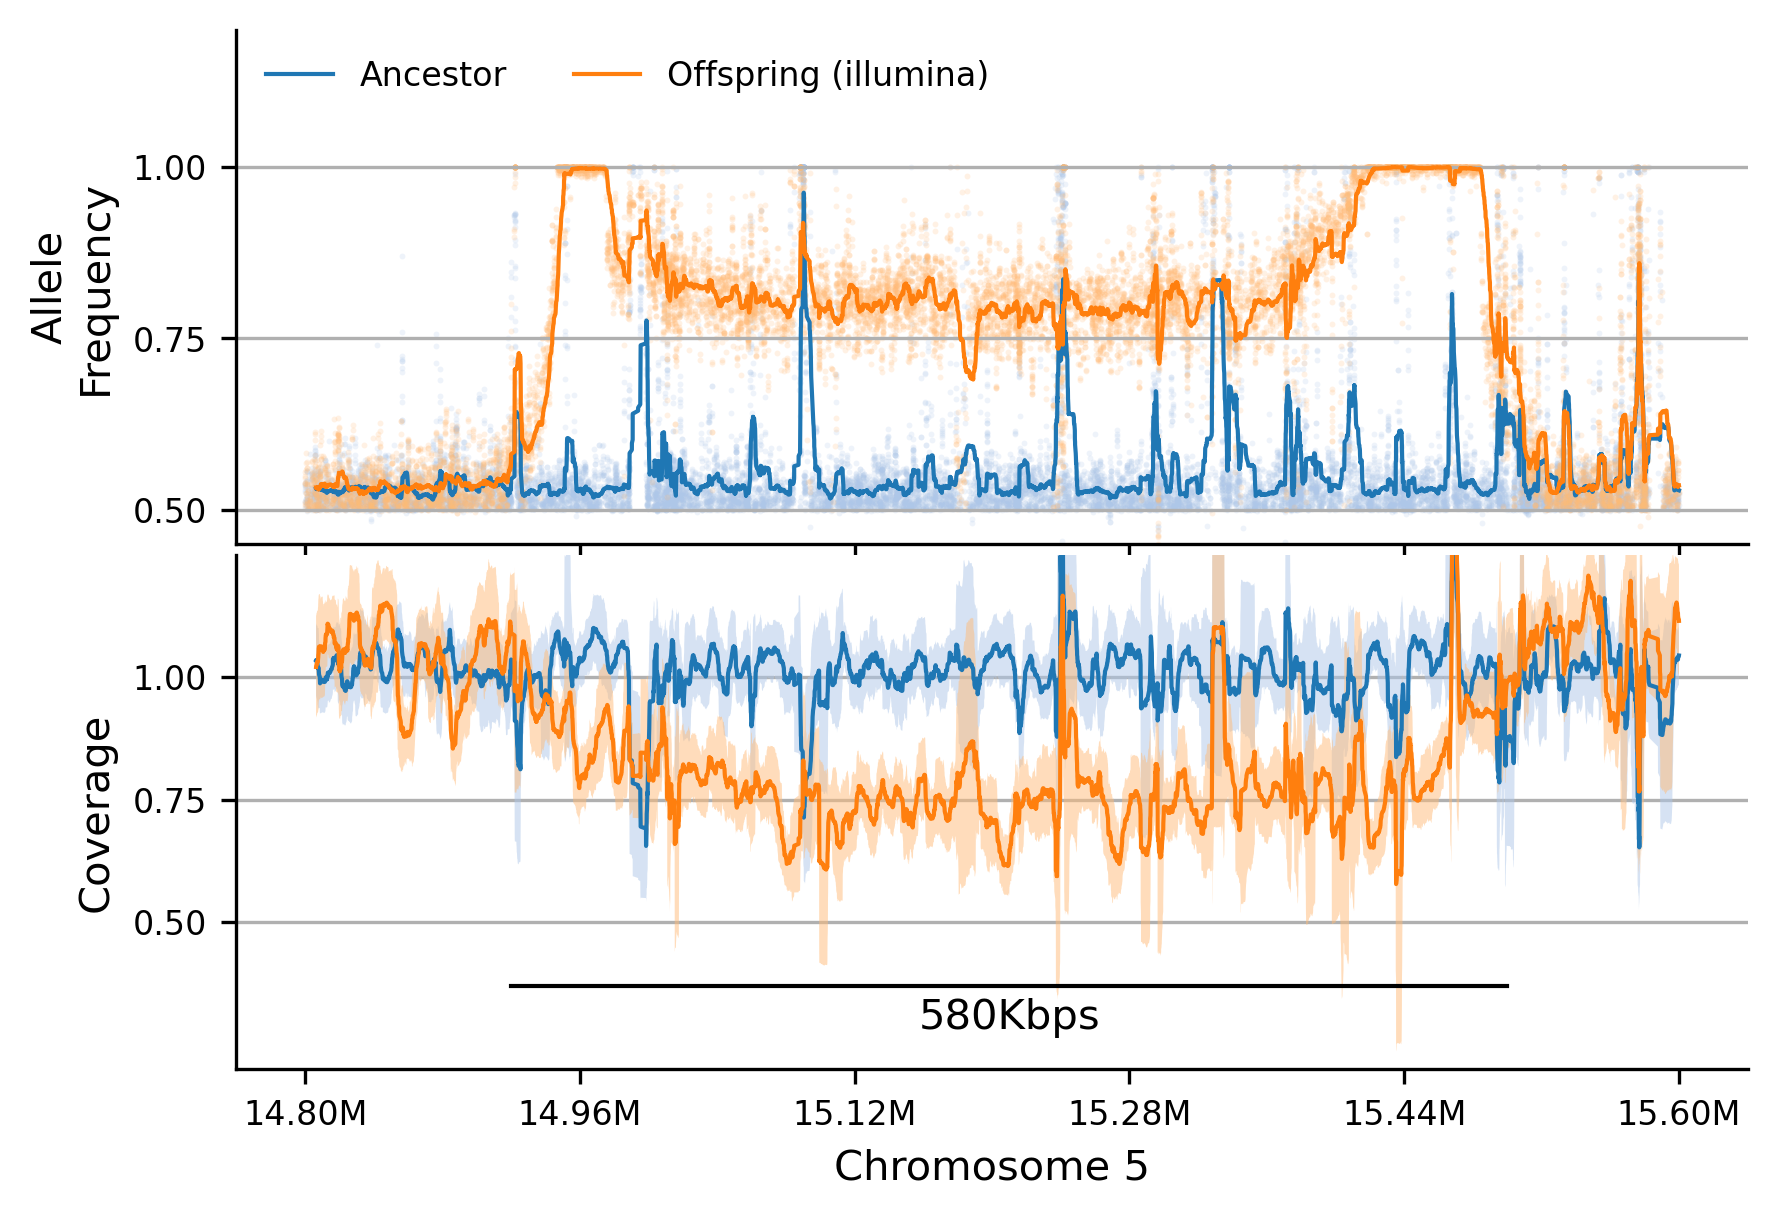

In [20]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6.5,4.5))

flt = total_df.query("POS > 14800000 & POS < 15600000 & QUAL >= 1000")
flt = flt.dropna()

ax = axs[0]

AAF = flt["AAF"].rolling(window=100).mean()
AAF_std = flt["AAF"].rolling(window=100).std()
IAF = flt["IAF"].rolling(window=100).mean()
IAF_std = flt["IAF"].rolling(window=100).std()

ax.scatter(flt["POS"], flt["AAF"], s=2, facecolor=colors[1]+[0.2], ec="k", lw=0.0, zorder=1)
ax.plot(flt["POS"], AAF, color=colors[0], lw=1.0, zorder=15, label="Ancestor")
#ax.fill_between(flt["POS"], AAF+AAF_std, AAF-AAF_std, facecolor=colors[1]+[0.5], zorder=10)

ax.scatter(flt["POS"], flt["IAF"], s=2, facecolor=colors[3]+[0.2], ec="k", lw=0.0, zorder=1)
ax.plot(flt["POS"], IAF, color=colors[2], lw=1.0, zorder=15, label="Offspring (illumina)")
#ax.fill_between(flt["POS"], IAF+IAF_std, IAF-IAF_std, facecolor=colors[3]+[0.5], zorder=10)

ax.yaxis.grid(True, zorder=1)
ax.set_ylim(0.45, 1.2)
ax.set_yticks([0.5, 0.75, 1.0])
ax.tick_params(labelsize=8)
ax.set_ylabel("Allele\nFrequency", fontsize=10)
ax.legend(ncol=3, fontsize=8, frameon=False, loc="upper left")

# Coverage
ax = axs[1]

ADP_scaled = flt["COV_ANC"]/341
Arol = ADP_scaled.rolling(window=100).mean()
Arol_std = ADP_scaled.rolling(window=100).std()

IDP_scaled = flt["COV_ILU"]/275
Irol = IDP_scaled.rolling(window=100).mean()
Irol_std = IDP_scaled.rolling(window=100).std()

ax.plot(flt["POS"], Arol, color=colors[0], lw=1.0, zorder=15, label="Ancestor")
ax.fill_between(flt["POS"], Arol+Arol_std, Arol-Arol_std, facecolor=colors[1]+[0.5], zorder=10)

ax.plot(flt["POS"], Irol, color=colors[2], lw=1.0, zorder=15, label="Offspring (illumina)")
ax.fill_between(flt["POS"], Irol+Irol_std, Irol-Irol_std, facecolor=colors[3]+[0.5], zorder=10)

ax.yaxis.grid(True, zorder=1)
ax.set_ylim(0.2, 1.25)
ax.set_yticks([0.5, 0.75, 1.0])
ax.tick_params(labelsize=8)
ax.set_ylabel("Coverage", fontsize=10)

start = min(flt["POS"])
end = max(flt["POS"])
ticks = np.linspace(start, end, 6)
ticklabels = []
for t in ticks :
    ticklabels.append("{:.2f}M".format(round(t/1000000, 2)))
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, fontsize=8) #, fontsize=12)
ax.set_xlabel("Chromosome 5", fontsize=10)

bs, be = 14920000, 15500000
byt = 0.37
ax.plot([bs, be], [byt, byt], color="k", lw=1.0, zorder=25)
ax.text(x=bs+((be-bs)/2), y=byt-0.025, s="{:.0f}Kbps".format((be-bs)/1e3), ha="center", va="top")

for ax in axs :
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.subplots_adjust(hspace=0.02)
plt.show()